In [1]:
#########################
### Import Code Stuff ###
#########################

### Numpy and Scipy
import numpy as np
from scipy.stats import binned_statistic
from scipy.optimize import minimize

### Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.offsetbox import AnchoredText

### MCMC
import emcee
# import time
import mcmc as mc

### Geometry
import lmcgeometry as lgeo

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

In [14]:
################
### LMC Data ###
################

### Import Data
lmc = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.r13-l33-58672.fits.gz',1)
cln = np.where((lmc['FE_H']>-9999.0)&(lmc['AK_TARG']>-9999.0)&(lmc['LOGG']>0.0)&(lmc['M_H_ERR']>-90.0)&
                (lmc['C_FE']>-9999.0)&(lmc['N_FE']>-9999.0))

lmc = lmc[cln]

elems = ['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',
         'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']
labs = ['[M/H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe]','[Ti/Fe]','[TiII/Fe]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge/Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/Fe]']

### LMC Geometry
x,y,dist = lgeo.LMCdisk_cart(lmc['RA'],lmc['DEC'])
radius = lgeo.elliptical_radius(x,y)

In [3]:
#############
### MCMC  ###
#############

ms = []
ms_err = []
bs = []
bs_err = []


for i in tqdm_notebook(range(len(elems)),desc='Progress'):
    cln = np.where((lmc[elems[i]]>-100.)&(lmc['SNR']>=100))
    
    rad_cln = radius[cln]
    abund_cln = lmc[elems[i]][cln]
#     abund_cln_err = lmc[elems[i]+'_ERR'][cln]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, _ = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        bin_stats_err, _, _ = binned_statistic(rad_cln,abund_cln,
                                               statistic=lambda y: np.median(np.absolute(y-np.median(y))),
                                               bins=bins)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)
    
#     print('{}: Slope {:.4f} +/- {:.4f}; Inter {:.4f} +/- {:.4f}'.format(elems[i],np.median(flat_samples[:,0]),
#                                                                         mc.mad(flat_samples[:,0]),
#                                                                         np.median(flat_samples[:,1]),
#                                                                         mc.mad(flat_samples[:,1])))
        ms.append(np.median(flat_samples[:,0]))
        ms_err.append(mc.mad(flat_samples[:,0]))
        bs.append(np.median(flat_samples[:,1]))
        bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        ms.append(-9999.0)
        ms_err.append(-9999.0)
        bs.append(-9999.0)
        bs_err.append(-9999.0)

100%|██████████| 5000/5000 [00:53<00:00, 94.17it/s]


In [4]:
for i in range(len(ms)-5):
    print('{}: slope: {:.4f} +/- {:.4f} inter: {:.4f} +/- {:.4f}'.format(elems[i],ms[i],ms_err[i],bs[i],
                                                                         bs_err[i]))

M_H: slope: -0.0414 +/- 0.0241 inter: -0.5890 +/- 0.0825
C_FE: slope: -0.0217 +/- 0.0130 inter: -0.2741 +/- 0.0440
N_FE: slope: -0.0119 +/- 0.0100 inter: 0.1472 +/- 0.0420
O_FE: slope: 0.0026 +/- 0.0042 inter: 0.0240 +/- 0.0143
NA_FE: slope: -0.0039 +/- 0.0188 inter: -0.1731 +/- 0.0553
MG_FE: slope: 0.0071 +/- 0.0066 inter: 0.0820 +/- 0.0232
AL_FE: slope: -0.0118 +/- 0.0121 inter: -0.3129 +/- 0.0405
SI_FE: slope: 0.0040 +/- 0.0060 inter: -0.0108 +/- 0.0198
P_FE: slope: 0.0330 +/- 0.0301 inter: -0.0129 +/- 0.0954
S_FE: slope: 0.0168 +/- 0.0225 inter: 0.1406 +/- 0.0696
K_FE: slope: 0.0213 +/- 0.0113 inter: -0.0600 +/- 0.0318
CA_FE: slope: -0.0013 +/- 0.0039 inter: 0.1053 +/- 0.0134
TI_FE: slope: 0.0201 +/- 0.0048 inter: -0.1332 +/- 0.0138
TIII_FE: slope: 0.0308 +/- 0.0214 inter: -0.1672 +/- 0.0577
V_FE: slope: -0.0036 +/- 0.0113 inter: -0.1036 +/- 0.0356
CR_FE: slope: -0.0063 +/- 0.0102 inter: 0.0624 +/- 0.0304
MN_FE: slope: -0.0249 +/- 0.0051 inter: -0.0162 +/- 0.0131
FE_H: slope: -0.03

In [5]:
elems_dis = []
for i in range(len(elems)-5):
    
    def trendline(x):
        return ms[i]*x+bs[i]
    
    cln = np.where((lmc[elems[i]]>-100)&(lmc['SNR']>=100))
    plug = trendline(radius[cln])
    dis = plug-lmc[elems[i]][cln]
    
    elems_dis.append(dis)

In [6]:
re_ms = []
re_ms_err = []
re_bs = []
re_bs_err = []

prune_fact = 3.
for i in tqdm_notebook(range(len(elems)-5),desc='Progress'):
    cln = np.where((lmc[elems[i]]>-100.)&(lmc['SNR']>=100))
    prune = np.where((lmc[elems[i]]>-prune_fact*mc.mad(elems_dis[i])+
                      np.median(lmc[cln][elems[i]]))&
                     (lmc[elems[i]]<prune_fact*mc.mad(elems_dis[i])+
                      np.median(lmc[cln][elems[i]])))

    rad_cln = radius[prune]
    abund_cln = lmc[elems[i]][prune]
#     endog_err = lmc[elems_err[i]][prune]
    
#     rad_cln = radius[cln]
#     abund_cln = lmc[elems[i]][cln]
#     abund_cln_err = lmc[elems[i]+'_ERR'][cln]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
#         bin_stats_err, _, _ = binned_statistic(rad_cln,abund_cln,
#                                                statistic=lambda y: np.median(np.absolute(y-np.median(y))),
#                                                bins=bins)
        
        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)
    
#     print('{}: Slope {:.4f} +/- {:.4f}; Inter {:.4f} +/- {:.4f}'.format(elems[i],np.median(flat_samples[:,0]),
#                                                                         mc.mad(flat_samples[:,0]),
#                                                                         np.median(flat_samples[:,1]),
#                                                                         mc.mad(flat_samples[:,1])))
        re_ms.append(np.median(flat_samples[:,0]))
        re_ms_err.append(mc.mad(flat_samples[:,0]))
        re_bs.append(np.median(flat_samples[:,1]))
        re_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        re_ms.append(-9999.0)
        re_ms_err.append(-9999.0)
        re_bs.append(-9999.0)
        re_bs_err.append(-9999.0)

100%|██████████| 5000/5000 [00:54<00:00, 91.11it/s]

In [7]:
for i in range(len(re_ms)):
    print('{}: slope: {:.4f} +/- {:.4f} inter: {:.4f} +/- {:.4f}'.format(elems[i],re_ms[i],re_ms_err[i],re_bs[i],
                                                                         re_bs_err[i]))

M_H: slope: -0.0268 +/- 0.0185 inter: -0.6013 +/- 0.0625
C_FE: slope: -0.0185 +/- 0.0088 inter: -0.2721 +/- 0.0349
N_FE: slope: -0.0106 +/- 0.0063 inter: 0.1195 +/- 0.0255
O_FE: slope: -0.0014 +/- 0.0027 inter: 0.0387 +/- 0.0126
NA_FE: slope: 0.0030 +/- 0.0169 inter: -0.1822 +/- 0.0549
MG_FE: slope: 0.0010 +/- 0.0057 inter: 0.1015 +/- 0.0217
AL_FE: slope: -0.0107 +/- 0.0111 inter: -0.3088 +/- 0.0375
SI_FE: slope: 0.0037 +/- 0.0048 inter: -0.0050 +/- 0.0171
P_FE: slope: 0.0260 +/- 0.0213 inter: 0.0292 +/- 0.0705
S_FE: slope: 0.0101 +/- 0.0221 inter: 0.1471 +/- 0.0692
K_FE: slope: 0.0110 +/- 0.0070 inter: -0.0355 +/- 0.0215
CA_FE: slope: -0.0020 +/- 0.0035 inter: 0.1077 +/- 0.0127
TI_FE: slope: 0.0001 +/- 0.0049 inter: -0.1077 +/- 0.0099
TIII_FE: slope: 0.0320 +/- 0.0105 inter: -0.1900 +/- 0.0220
V_FE: slope: -0.0037 +/- 0.0097 inter: -0.0918 +/- 0.0315
CR_FE: slope: -0.0076 +/- 0.0079 inter: 0.0720 +/- 0.0278
MN_FE: slope: -0.0124 +/- 0.0042 inter: -0.0403 +/- 0.0119
FE_H: slope: -0.022

MLE Method:

M_H: slope: -0.0266 +/- 0.0025 inter: -0.6023 +/- 0.0092

C_FE: slope: -0.0177 +/- 0.0019 inter: -0.2743 +/- 0.0066

N_FE: slope: -0.0096 +/- 0.0016 inter: 0.1177 +/- 0.0063

O_FE: slope: 0.0002 +/- 0.0015 inter: 0.0340 +/- 0.0041

NA_FE: slope: 0.0015 +/- 0.0036 inter: -0.1785 +/- 0.0123

MG_FE: slope: 0.0025 +/- 0.0020 inter: 0.0973 +/- 0.0060

AL_FE: slope: -0.0101 +/- 0.0015 inter: -0.3117 +/- 0.0058

SI_FE: slope: 0.0042 +/- 0.0013 inter: -0.0062 +/- 0.0044

P_FE: slope: 0.0237 +/- 0.0046 inter: 0.0363 +/- 0.0159

S_FE: slope: 0.0091 +/- 0.0029 inter: 0.1513 +/- 0.0097

K_FE: slope: 0.0116 +/- 0.0037 inter: -0.0373 +/- 0.0109

CA_FE: slope: -0.0017 +/- 0.0006 inter: 0.1070 +/- 0.0016

TI_FE: slope: 0.0009 +/- 0.0037 inter: -0.1096 +/- 0.0084

TIII_FE: slope: 0.0287 +/- 0.0061 inter: -0.1774 +/- 0.0198

V_FE: slope: -0.0037 +/- 0.0017 inter: -0.0915 +/- 0.0065

CR_FE: slope: -0.0081 +/- 0.0015 inter: 0.0731 +/- 0.0041

MN_FE: slope: -0.0155 +/- 0.0023 inter: -0.0347 +/- 0.0063

FE_H: slope: -0.0225 +/- 0.0023 inter: -0.6088 +/- 0.0091

CO_FE: slope: -0.0059 +/- 0.0018 inter: -0.1229 +/- 0.0056

NI_FE: slope: -0.0010 +/- 0.0007 inter: -0.1273 +/- 0.0025

CU_FE: slope: 0.0213 +/- 0.0055 inter: 0.0541 +/- 0.0165

<font size='30'>
    <b>
        AGES BINS
    </b>
</font>

In [8]:
# Ages
# ages = fits.getdata('pca_ols_ages.fits')
ages = fits.getdata('TEST_pca_ols_ages.fits')

#####################
### Make Age Bins ###
#####################

young = np.where(ages['AGE']<=np.log10(0.5*10**9))
yless = np.where((ages['AGE']>np.log10(0.5*10**9))&(ages['AGE']<=np.log10(2.0*10**9)))
ymed = np.where((ages['AGE']>np.log10(2.0*10**9))&(ages['AGE']<=np.log10(7*10**9)))
omed = np.where((ages['AGE']>np.log10(7*10**9))&(ages['AGE']<=np.log10(10.5*10**9)))
old = np.where(ages['AGE']>np.log10(10.5*10**9))

lmcyoung = lmc[young]
lmcyless = lmc[yless]
lmcymed = lmc[ymed]
lmcomed = lmc[omed]
lmcold = lmc[old]

In [9]:
##################################
### Age bin initial Trendlines ###
##################################

### young

young_ms = []
young_ms_err = []
young_bs = []
young_bs_err = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    cln = np.where((lmcyoung[elems[i]]>-100.)&(lmcyoung['SNR']>=100))
    rad_cln = radius[young][cln]
    abund_cln = lmcyoung[elems[i]][cln]
#     abund_cln_err = lmc[elems[i]+'_ERR'][cln]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

        young_ms.append(np.median(flat_samples[:,0]))
        young_ms_err.append(mc.mad(flat_samples[:,0]))
        young_bs.append(np.median(flat_samples[:,1]))
        young_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        young_ms.append(-9999.0)
        young_ms_err.append(-9999.0)
        young_bs.append(-9999.0)
        young_bs_err.append(-9999.0)
    
## yless

yless_ms = []
yless_ms_err = []
yless_bs = []
yless_bs_err = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    cln = np.where((lmcyless[elems[i]]>-100.)&(lmcyless['SNR']>=100))
    rad_cln = radius[yless][cln]
    abund_cln = lmcyless[elems[i]][cln]
#     abund_cln_err = lmc[elems[i]+'_ERR'][cln]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

        yless_ms.append(np.median(flat_samples[:,0]))
        yless_ms_err.append(mc.mad(flat_samples[:,0]))
        yless_bs.append(np.median(flat_samples[:,1]))
        yless_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        yless_ms.append(-9999.0)
        yless_ms_err.append(-9999.0)
        yless_bs.append(-9999.0)
        yless_bs_err.append(-9999.0)
        
### ymed

ymed_ms = []
ymed_ms_err = []
ymed_bs = []
ymed_bs_err = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    cln = np.where((lmcymed[elems[i]]>-100.)&(lmcymed['SNR']>=100))
    rad_cln = radius[ymed][cln]
    abund_cln = lmcymed[elems[i]][cln]
#     abund_cln_err = lmc[elems[i]+'_ERR'][cln]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

        ymed_ms.append(np.median(flat_samples[:,0]))
        ymed_ms_err.append(mc.mad(flat_samples[:,0]))
        ymed_bs.append(np.median(flat_samples[:,1]))
        ymed_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        ymed_ms.append(-9999.0)
        ymed_ms_err.append(-9999.0)
        ymed_bs.append(-9999.0)
        ymed_bs_err.append(-9999.0)
        
### omed

omed_ms = []
omed_ms_err = []
omed_bs = []
omed_bs_err = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    cln = np.where((lmcomed[elems[i]]>-100.)&(lmcomed['SNR']>=100))
    rad_cln = radius[omed][cln]
    abund_cln = lmcomed[elems[i]][cln]
#     abund_cln_err = lmc[elems[i]+'_ERR'][cln]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

        omed_ms.append(np.median(flat_samples[:,0]))
        omed_ms_err.append(mc.mad(flat_samples[:,0]))
        omed_bs.append(np.median(flat_samples[:,1]))
        omed_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        omed_ms.append(-9999.0)
        omed_ms_err.append(-9999.0)
        omed_bs.append(-9999.0)
        omed_bs_err.append(-9999.0)

### old

old_ms = []
old_ms_err = []
old_bs = []
old_bs_err = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    cln = np.where((lmcold[elems[i]]>-100.)&(lmcold['SNR']>=100))
    rad_cln = radius[old][cln]
    abund_cln = lmcold[elems[i]][cln]
#     abund_cln_err = lmc[elems[i]+'_ERR'][cln]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

        old_ms.append(np.median(flat_samples[:,0]))
        old_ms_err.append(mc.mad(flat_samples[:,0]))
        old_bs.append(np.median(flat_samples[:,1]))
        old_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        old_ms.append(-9999.0)
        old_ms_err.append(-9999.0)
        old_bs.append(-9999.0)
        old_bs_err.append(-9999.0)

100%|██████████| 5000/5000 [00:51<00:00, 97.46it/s] 

100%|██████████| 5000/5000 [00:48<00:00, 102.23it/s]

100%|██████████| 5000/5000 [00:49<00:00, 102.03it/s]

100%|██████████| 5000/5000 [00:48<00:00, 102.64it/s]

100%|██████████| 5000/5000 [00:49<00:00, 101.64it/s]

In [10]:
############################################
### Find distances between data and fits ###
############################################

young_dist = []
for i in range(len(elems)-5):
    
    def trendline(x):
        return young_ms[i]*x+young_bs[i]
    
    cln = np.where((lmcyoung[elems[i]]>-100))
    plug = trendline(radius[young][cln])
    dist = plug-lmcyoung[elems[i]][cln]
    
    young_dist.append(dist) 
    
yless_dist = []
for i in range(len(elems)-5):
    
    def trendline(x):
        return yless_ms[i]*x+yless_bs[i]
    
    cln = np.where((lmcyless[elems[i]]>-100))
    plug = trendline(radius[yless][cln])
    dist = plug-lmcyless[elems[i]][cln]
    
    yless_dist.append(dist) 
    
ymed_dist = []
for i in range(len(elems)-5):
    
    def trendline(x):
        return ymed_ms[i]*x+ymed_bs[i]
    
    cln = np.where((lmcymed[elems[i]]>-100))
    plug = trendline(radius[ymed][cln])
    dist = plug-lmcymed[elems[i]][cln]
    
    ymed_dist.append(dist) 
    
omed_dist = []
for i in range(len(elems)-5):
    
    def trendline(x):
        return omed_ms[i]*x+omed_bs[i]
    
    cln = np.where((lmcomed[elems[i]]>-100))
    plug = trendline(radius[omed][cln])
    dist = plug-lmcomed[elems[i]][cln]
    
    omed_dist.append(dist) 
    
old_dist = []
for i in range(len(elems)-5):
    
    def trendline(x):
        return old_ms[i]*x+old_bs[i]
    
    cln = np.where((lmcold[elems[i]]>-100))
    plug = trendline(radius[old][cln])
    dist = plug-lmcold[elems[i]][cln]
    
    old_dist.append(dist)

In [11]:
#################################
### Second Age bin Trendlines ###
#################################

prune_fact = 3.

### young

re_young_ms = []
re_young_ms_err = []
re_young_bs = []
re_young_bs_err = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    cln = np.where((lmcyoung[elems[i]]>-100))
    prune = np.where((lmcyoung[elems[i]]>-prune_fact*mc.mad(young_dist[i])+
                      np.median(lmcyoung[cln][elems[i]]))&
                     (lmcyoung[elems[i]]<prune_fact*mc.mad(young_dist[i])+
                      np.median(lmcyoung[cln][elems[i]])))
    
    rad_cln = radius[young][prune]
    abund_cln = lmcyoung[elems[i]][prune]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

        re_young_ms.append(np.median(flat_samples[:,0]))
        re_young_ms_err.append(mc.mad(flat_samples[:,0]))
        re_young_bs.append(np.median(flat_samples[:,1]))
        re_young_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        re_young_ms.append(-9999.0)
        re_young_ms_err.append(-9999.0)
        re_young_bs.append(-9999.0)
        re_young_bs_err.append(-9999.0)
    
## yless

re_yless_ms = []
re_yless_ms_err = []
re_yless_bs = []
re_yless_bs_err = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    cln = np.where((lmcyless[elems[i]]>-100))
    prune = np.where((lmcyless[elems[i]]>-prune_fact*mc.mad(yless_dist[i])+
                      np.median(lmcyless[cln][elems[i]]))&
                     (lmcyless[elems[i]]<prune_fact*mc.mad(yless_dist[i])+
                      np.median(lmcyless[cln][elems[i]])))
    
    rad_cln = radius[yless][prune]
    abund_cln = lmcyless[elems[i]][prune]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

        re_yless_ms.append(np.median(flat_samples[:,0]))
        re_yless_ms_err.append(mc.mad(flat_samples[:,0]))
        re_yless_bs.append(np.median(flat_samples[:,1]))
        re_yless_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        re_yless_ms.append(-9999.0)
        re_yless_ms_err.append(-9999.0)
        re_yless_bs.append(-9999.0)
        re_yless_bs_err.append(-9999.0)
        
### ymed

re_ymed_ms = []
re_ymed_ms_err = []
re_ymed_bs = []
re_ymed_bs_err = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    cln = np.where((lmcymed[elems[i]]>-100))
    prune = np.where((lmcymed[elems[i]]>-prune_fact*mc.mad(ymed_dist[i])+
                      np.median(lmcymed[cln][elems[i]]))&
                     (lmcymed[elems[i]]<prune_fact*mc.mad(ymed_dist[i])+
                      np.median(lmcymed[cln][elems[i]])))
    
    rad_cln = radius[ymed][prune]
    abund_cln = lmcymed[elems[i]][prune]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)

        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

        re_ymed_ms.append(np.median(flat_samples[:,0]))
        re_ymed_ms_err.append(mc.mad(flat_samples[:,0]))
        re_ymed_bs.append(np.median(flat_samples[:,1]))
        re_ymed_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        re_ymed_ms.append(-9999.0)
        re_ymed_ms_err.append(-9999.0)
        re_ymed_bs.append(-9999.0)
        re_ymed_bs_err.append(-9999.0)
        
### omed

re_omed_ms = []
re_omed_ms_err = []
re_omed_bs = []
re_omed_bs_err = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    cln = np.where((lmcomed[elems[i]]>-100))
    prune = np.where((lmcomed[elems[i]]>-prune_fact*mc.mad(omed_dist[i])+
                      np.median(lmcomed[cln][elems[i]]))&
                     (lmcomed[elems[i]]<prune_fact*mc.mad(omed_dist[i])+
                      np.median(lmcomed[cln][elems[i]])))
    
    rad_cln = radius[omed][prune]
    abund_cln = lmcomed[elems[i]][prune]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)
    
        re_omed_ms.append(np.median(flat_samples[:,0]))
        re_omed_ms_err.append(mc.mad(flat_samples[:,0]))
        re_omed_bs.append(np.median(flat_samples[:,1]))
        re_omed_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        re_omed_ms.append(-9999.0)
        re_omed_ms_err.append(-9999.0)
        re_omed_bs.append(-9999.0)
        re_omed_bs_err.append(-9999.0)

### old

re_old_ms = []
re_old_ms_err = []
re_old_bs = []
re_old_bs_err = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    cln = np.where((lmcold[elems[i]]>-100))
    prune = np.where((lmcold[elems[i]]>-prune_fact*mc.mad(old_dist[i])+
                      np.median(lmcold[cln][elems[i]]))&
                     (lmcold[elems[i]]<prune_fact*mc.mad(old_dist[i])+
                      np.median(lmcold[cln][elems[i]])))
    
    
    rad_cln = radius[old][prune]
    abund_cln = lmcold[elems[i]][prune]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

        re_old_ms.append(np.median(flat_samples[:,0]))
        re_old_ms_err.append(mc.mad(flat_samples[:,0]))
        re_old_bs.append(np.median(flat_samples[:,1]))
        re_old_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        re_old_ms.append(-9999.0)
        re_old_ms_err.append(-9999.0)
        re_old_bs.append(-9999.0)
        re_old_bs_err.append(-9999.0)

100%|██████████| 5000/5000 [00:49<00:00, 101.92it/s]

100%|██████████| 5000/5000 [00:18<00:00, 272.81it/s]

100%|██████████| 5000/5000 [00:16<00:00, 297.58it/s]


100%|██████████| 5000/5000 [00:16<00:00, 306.93it/s]

100%|██████████| 5000/5000 [00:16<00:00, 302.06it/s]

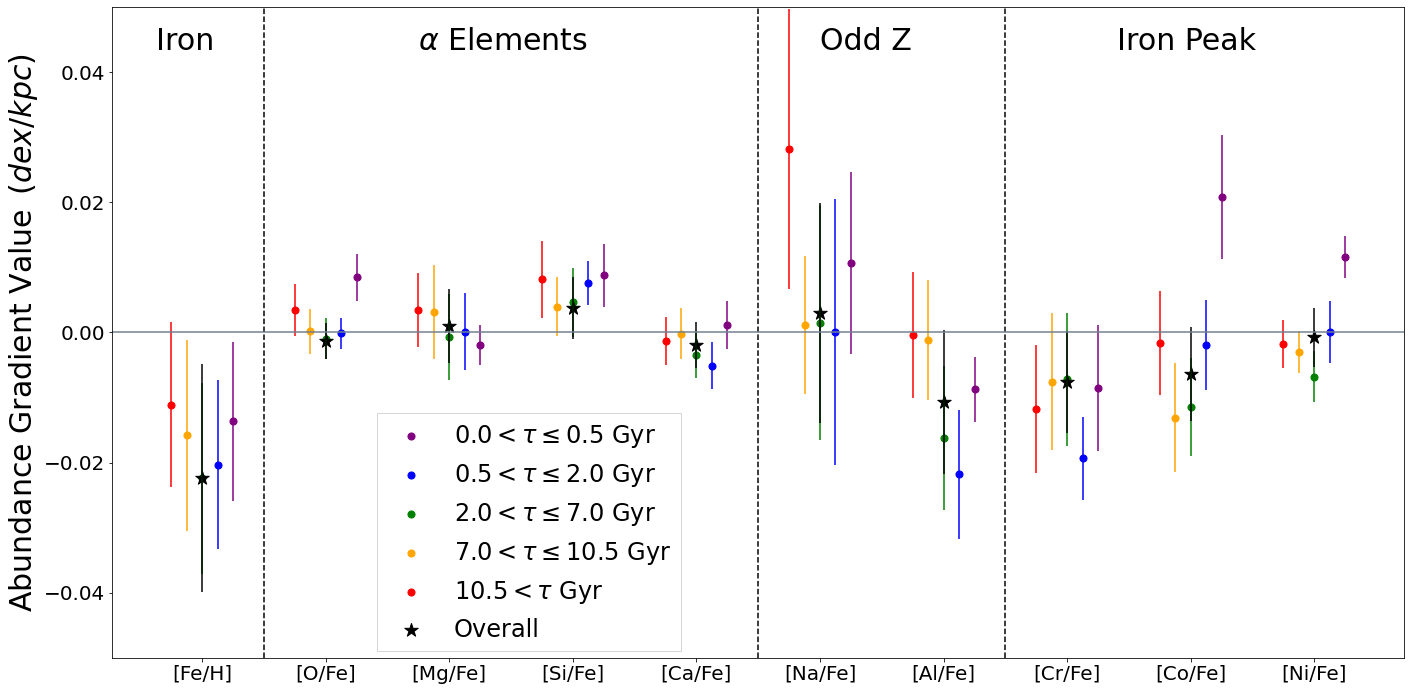

In [12]:
####################
### Summary plot ###
####################

# elements: O, Na, Mg, Al, Si, Ca, Cr, Fe, Co, Ni, V

idx = [np.squeeze(np.where(np.asarray(elems)=='FE_H')),np.squeeze(np.where(np.asarray(elems)=='O_FE')),
       np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='SI_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CA_FE')),np.squeeze(np.where(np.asarray(elems)=='NA_FE')),
       np.squeeze(np.where(np.asarray(elems)=='AL_FE')),np.squeeze(np.where(np.asarray(elems)=='CR_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CO_FE')),np.squeeze(np.where(np.asarray(elems)=='NI_FE'))]#,
       #np.squeeze(np.where(np.asarray(elems)=='V_FE'))]

good_young = []
good_yless = []
good_ymed = []
good_omed = []
good_old = []
good_over = []

err_young = []
err_yless = []
err_ymed = []
err_omed = []
err_old = []
err_over = []

for i in idx:
    good_young.append(re_young_ms[i])
    good_yless.append(re_yless_ms[i])
    good_ymed.append(re_ymed_ms[i])
    good_omed.append(re_omed_ms[i])
    good_old.append(re_old_ms[i])
    good_over.append(re_ms[i])
    
    err_young.append(re_young_ms_err[i])
    err_yless.append(re_yless_ms_err[i])
    err_ymed.append(re_ymed_ms_err[i])
    err_omed.append(re_omed_ms_err[i])
    err_old.append(re_old_ms_err[i])
    err_over.append(re_ms_err[i])

matplotlib.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=[20,10])

plt.scatter(np.add(np.arange(10),0.25),good_young,c='purple',label='$0.0 < \\tau \leq 0.5$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.25),good_young,yerr=err_young,c='purple',ls='none')

plt.scatter(np.add(np.arange(10),0.125),good_yless,c='blue',label='$0.5 < \\tau \leq 2.0$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.125),good_yless,yerr=err_yless,c='blue',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_ymed,c='green',label='$2.0 < \\tau \leq 7.0$ Gyr',s=50)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_ymed,yerr=err_ymed,c='green',ls='none')

plt.scatter(np.subtract(np.arange(10),0.125),good_omed,c='orange',label='$7.0 < \\tau \leq 10.5$ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.125),good_omed,yerr=err_omed,c='orange',ls='none')

plt.scatter(np.subtract(np.arange(10),0.25),good_old,c='red',label='$10.5 < \\tau $ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.25),good_old,yerr=err_old,c='red',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_over,marker='*',c='black',label='Overall',s=200)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_over,yerr=err_over,c='black',ls='none')

xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]',
            '[Ni/Fe]']#,'[V/Fe]']

xplotpos = [0,1,2,3,4,5,6,7,8,9]#,10] 
plt.xticks(xplotpos,xplotlab)

plt.axvline(0.5,c='k',ls='--')
plt.axvline(4.5,c='k',ls='--')
plt.axvline(6.5,c='k',ls='--')
plt.axhline(0.0,c='slategrey',ls='-')
plt.ylabel('Abundance Gradient Value $\,(dex/kpc)$',fontsize=30)

# plt.gca().set_ylim(top=0.05)

plt.text(-0.375,0.0435,'Iron',fontsize=30)
plt.text(1.75,0.0435,'$\\alpha$ Elements',fontsize=30)
plt.text(5.0,0.0435,'Odd Z',fontsize=30)
plt.text(7.4,0.0435,'Iron Peak',fontsize=30)

# plt.ylim(bottom=-0.045)
plt.ylim(-0.05,0.05)

plt.legend(loc=(0.205,0.01),frameon=True,fancybox=False,fontsize='large')
plt.tight_layout()
plt.savefig('MCMCgradientSummaryplot.pdf',bbox_inches='tight')
plt.show()

In [ ]:
for i in range(len(elems)-5):
    cln = np.where((lmcold[elems[i]]>-100))
    prune = np.where((lmcold[elems[i]]>-prune_fact*mc.mad(old_dist[i])+
                      np.median(lmcold[cln][elems[i]]))&
                     (lmcold[elems[i]]<prune_fact*mc.mad(old_dist[i])+
                      np.median(lmcold[cln][elems[i]])))
    
    rad_cln = radius[old][prune]
    abund_cln = lmcold[elems[i]][prune]
    
    try:
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1)
        old_bin_stats, old_bin_edges, old_binnumber = binned_statistic(rad_cln,abund_cln,
                                                                             statistic='median',bins=bins)
        old_mad, _, _ = binned_statistic(rad_cln,abund_cln,statistic=lambda y: mc.mad(y),bins=bins)
                                                                        
        old_stats.append(old_bin_stats)
        old_edges.append(old_bin_edges)
        old_number.append(old_binnumber)
        old_spread.append(old_mad)
        
    
    except:
        old_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        old_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        old_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        old_spread.append(np.multiply(-9999.0,np.ones(len(bins)-1)))

In [23]:
prune_fact = 3.0

# radiusyoung = radius[young]
# radiusyless = radius[yless]
# radiusymed = radius[ymed]
# radiusomed = radius[omed]
# radiusold = radius[old]

### young
young_stats = [] 
young_edges = []
young_number = []
young_spread = []

for i in range(len(elems)-5):
    cln = np.where((lmcyoung[elems[i]]>-100))
    prune = np.where((lmcyoung[elems[i]]>-prune_fact*mc.mad(young_dist[i])+
                      np.median(lmcyoung[cln][elems[i]]))&
                     (lmcyoung[elems[i]]<prune_fact*mc.mad(young_dist[i])+
                      np.median(lmcyoung[cln][elems[i]])))
    
    rad_cln = radius[young][prune]
    abund_cln = lmcyoung[elems[i]][prune]
    
    try:
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1)
        young_bin_stats, young_bin_edges, young_binnumber = binned_statistic(rad_cln,abund_cln,
                                                                             statistic='median',bins=bins)
        young_mad, _, _ = binned_statistic(rad_cln,abund_cln,statistic=lambda y: mc.mad(y),bins=bins)
                                                                        
        young_stats.append(young_bin_stats)
        young_edges.append(young_bin_edges)
        young_number.append(young_binnumber)
        young_spread.append(young_mad)
        
    
    except:
        young_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        young_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        young_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        young_spread.append(np.multiply(-9999.0,np.ones(len(bins)-1)))

        
### yless
yless_stats = [] 
yless_edges = []
yless_number = []
yless_spread = []

for i in range(len(elems)-5):
    cln = np.where((lmcyless[elems[i]]>-100))
    prune = np.where((lmcyless[elems[i]]>-prune_fact*mc.mad(yless_dist[i])+
                      np.median(lmcyless[cln][elems[i]]))&
                     (lmcyless[elems[i]]<prune_fact*mc.mad(yless_dist[i])+
                      np.median(lmcyless[cln][elems[i]])))
    
    rad_cln = radius[yless][prune]
    abund_cln = lmcyless[elems[i]][prune]
    
    try:
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1)
        yless_bin_stats, yless_bin_edges, yless_binnumber = binned_statistic(rad_cln,abund_cln,
                                                                             statistic='median',bins=bins)
        yless_mad, _, _ = binned_statistic(rad_cln,abund_cln,statistic=lambda y: mc.mad(y),bins=bins)
                                                                        
        yless_stats.append(yless_bin_stats)
        yless_edges.append(yless_bin_edges)
        yless_number.append(yless_binnumber)
        yless_spread.append(yless_mad)
        
    
    except:
        yless_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        yless_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        yless_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        yless_spread.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        
### ymed
ymed_stats = [] 
ymed_edges = []
ymed_number = []
ymed_spread = []

for i in range(len(elems)-5):
    cln = np.where((lmcymed[elems[i]]>-100))
    prune = np.where((lmcymed[elems[i]]>-prune_fact*mc.mad(ymed_dist[i])+
                      np.median(lmcymed[cln][elems[i]]))&
                     (lmcymed[elems[i]]<prune_fact*mc.mad(ymed_dist[i])+
                      np.median(lmcymed[cln][elems[i]])))
    
    rad_cln = radius[ymed][prune]
    abund_cln = lmcymed[elems[i]][prune]
    
    try:
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1)
        ymed_bin_stats, ymed_bin_edges, ymed_binnumber = binned_statistic(rad_cln,abund_cln,
                                                                             statistic='median',bins=bins)
        ymed_mad, _, _ = binned_statistic(rad_cln,abund_cln,statistic=lambda y: mc.mad(y),bins=bins)
                                                                        
        ymed_stats.append(ymed_bin_stats)
        ymed_edges.append(ymed_bin_edges)
        ymed_number.append(ymed_binnumber)
        ymed_spread.append(ymed_mad)
        
    
    except:
        ymed_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        ymed_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        ymed_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        ymed_spread.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        
### omed
omed_stats = [] 
omed_edges = []
omed_number = []
omed_spread = []

for i in range(len(elems)-5):
    cln = np.where((lmcomed[elems[i]]>-100))
    prune = np.where((lmcomed[elems[i]]>-prune_fact*mc.mad(omed_dist[i])+
                      np.median(lmcomed[cln][elems[i]]))&
                     (lmcomed[elems[i]]<prune_fact*mc.mad(omed_dist[i])+
                      np.median(lmcomed[cln][elems[i]])))
    
    rad_cln = radius[omed][prune]
    abund_cln = lmcomed[elems[i]][prune]
    
    try:
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1)
        omed_bin_stats, omed_bin_edges, omed_binnumber = binned_statistic(rad_cln,abund_cln,
                                                                             statistic='median',bins=bins)
        omed_mad, _, _ = binned_statistic(rad_cln,abund_cln,statistic=lambda y: mc.mad(y),bins=bins)
                                                                        
        omed_stats.append(omed_bin_stats)
        omed_edges.append(omed_bin_edges)
        omed_number.append(omed_binnumber)
        omed_spread.append(omed_mad)
        
    
    except:
        omed_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        omed_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        omed_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        omed_spread.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        
### old
old_stats = [] 
old_edges = []
old_number = []
old_spread = []

for i in range(len(elems)-5):
    cln = np.where((lmcold[elems[i]]>-100))
    prune = np.where((lmcold[elems[i]]>-prune_fact*mc.mad(old_dist[i])+
                      np.median(lmcold[cln][elems[i]]))&
                     (lmcold[elems[i]]<prune_fact*mc.mad(old_dist[i])+
                      np.median(lmcold[cln][elems[i]])))
    
    rad_cln = radius[old][prune]
    abund_cln = lmcold[elems[i]][prune]
    
    try:
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1)
        old_bin_stats, old_bin_edges, old_binnumber = binned_statistic(rad_cln,abund_cln,
                                                                             statistic='median',bins=bins)
        old_mad, _, _ = binned_statistic(rad_cln,abund_cln,statistic=lambda y: mc.mad(y),bins=bins)
                                                                        
        old_stats.append(old_bin_stats)
        old_edges.append(old_bin_edges)
        old_number.append(old_binnumber)
        old_spread.append(old_mad)
        
    
    except:
        old_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        old_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        old_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        old_spread.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        
### overall
over_stats = [] 
over_edges = []
over_number = []
over_spread = []

for i in range(len(elems)-5):
    cln = np.where((lmc[elems[i]]>-100))
    prune = np.where((lmc[elems[i]]>-prune_fact*mc.mad(elems_dis[i])+
                      np.median(lmc[cln][elems[i]]))&
                     (lmc[elems[i]]<prune_fact*mc.mad(elems_dis[i])+
                      np.median(lmc[cln][elems[i]])))
    
    rad_cln = radius[prune]
    abund_cln = lmc[elems[i]][prune]
    
    try:
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1)
        over_bin_stats, over_bin_edges, over_binnumber = binned_statistic(rad_cln,abund_cln,
                                                                             statistic='median',bins=bins)
        over_mad, _, _ = binned_statistic(rad_cln,abund_cln,statistic=lambda y: mc.mad(y),bins=bins)
                                                                        
        over_stats.append(over_bin_stats)
        over_edges.append(over_bin_edges)
        over_number.append(over_binnumber)
        over_spread.append(over_mad)
        
    
    except:
        over_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        over_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        over_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        over_spread.append(np.multiply(-9999.0,np.ones(len(bins)-1)))

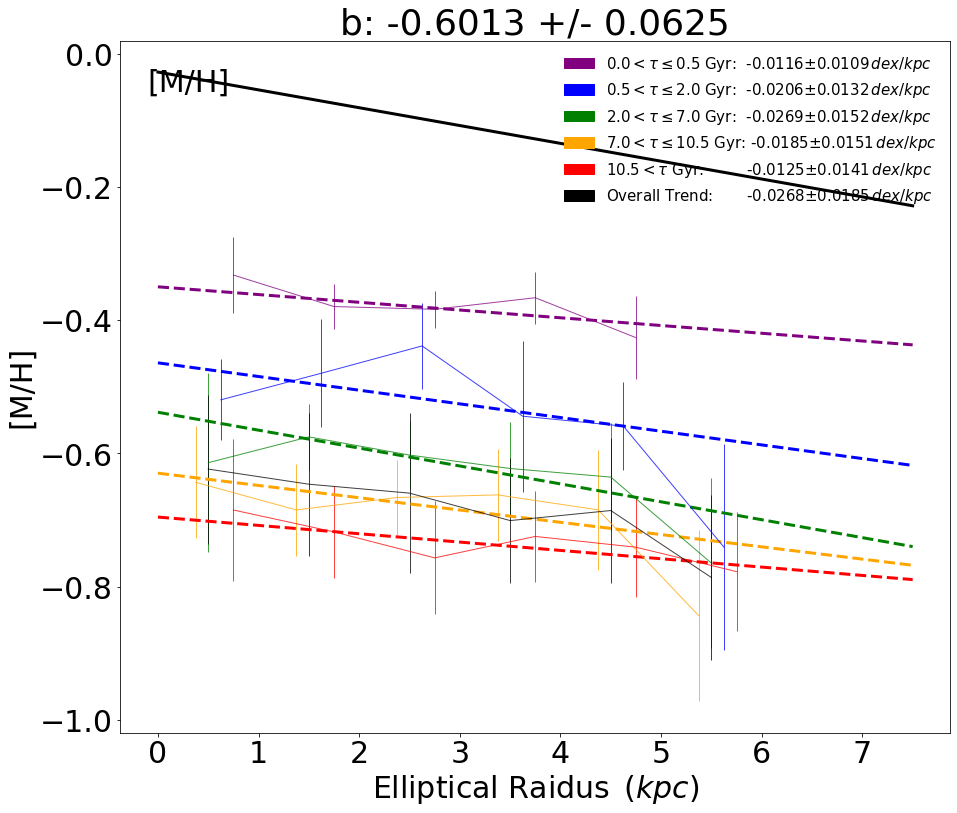

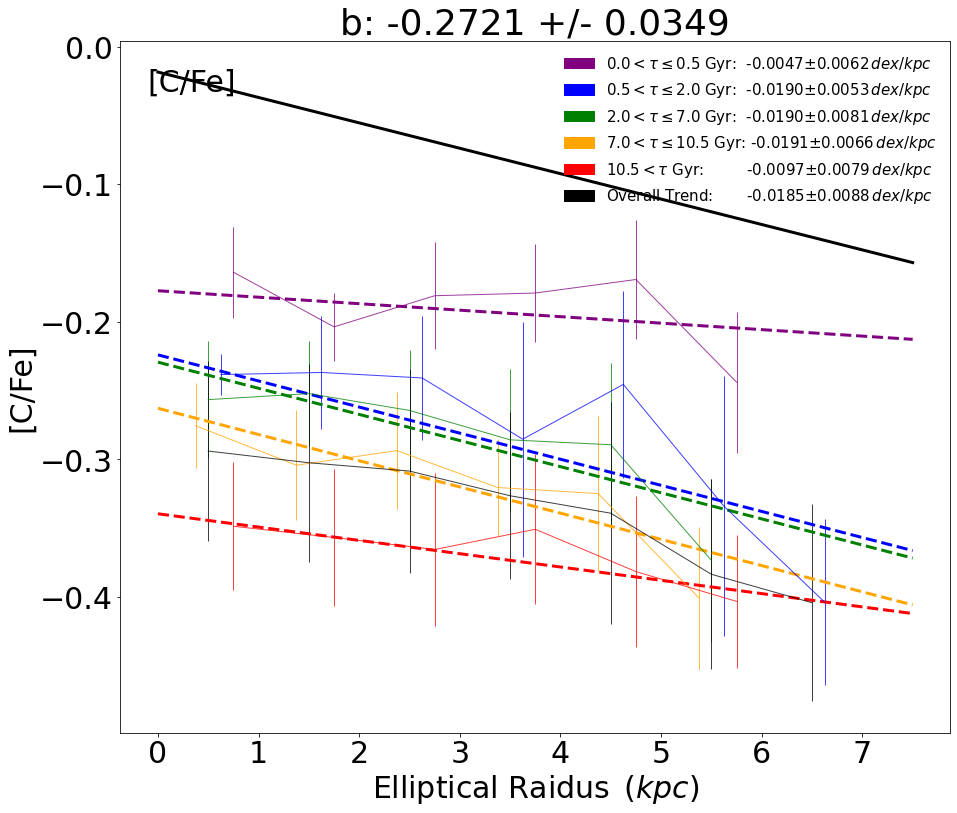

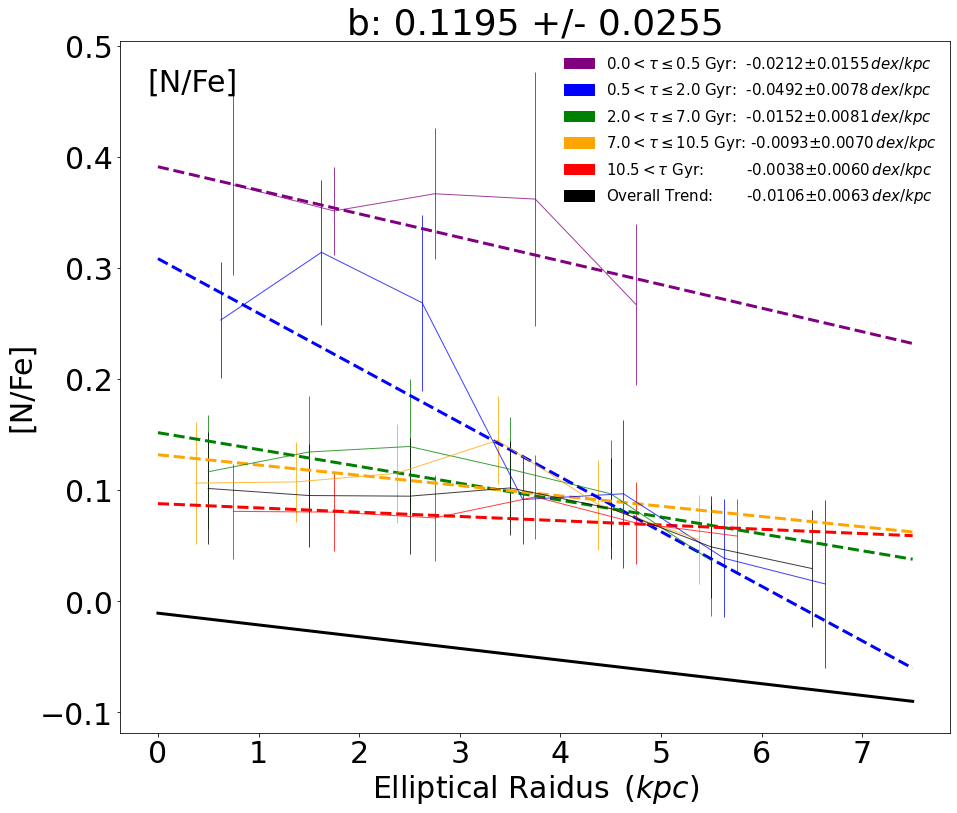

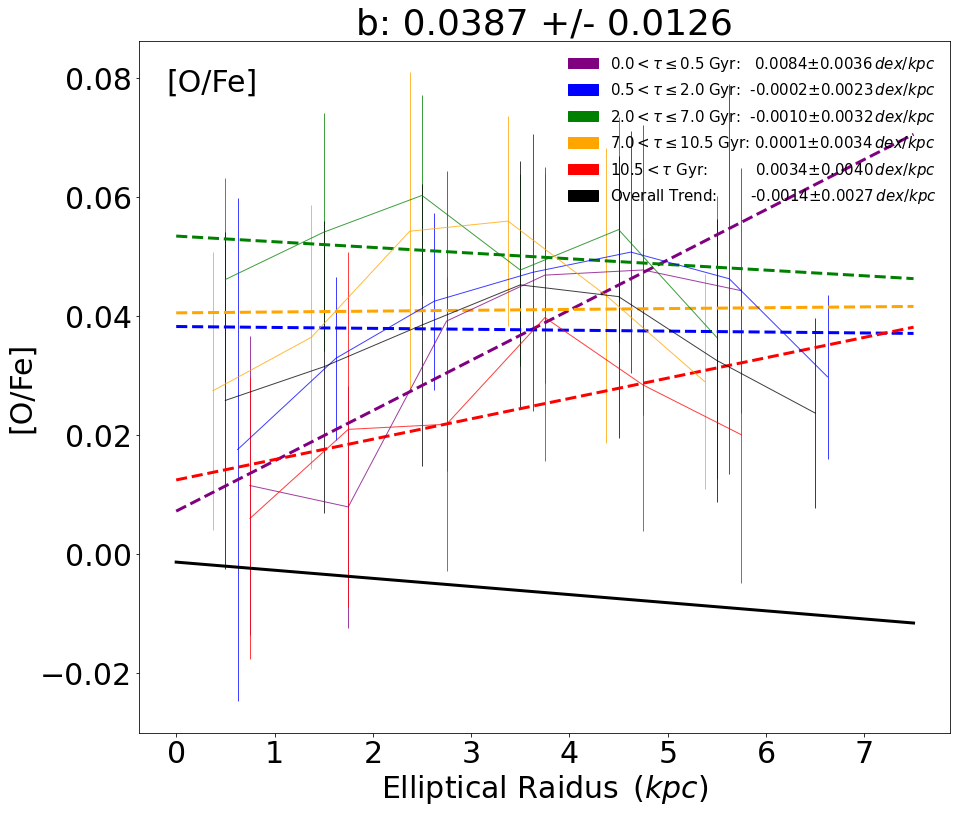

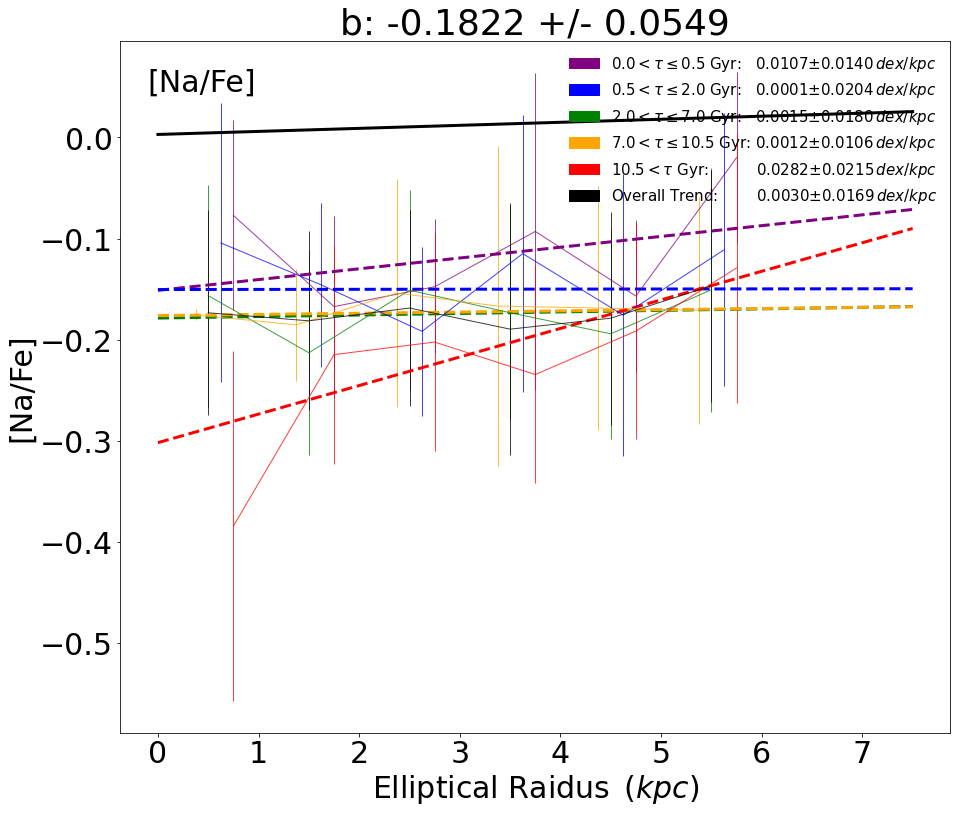

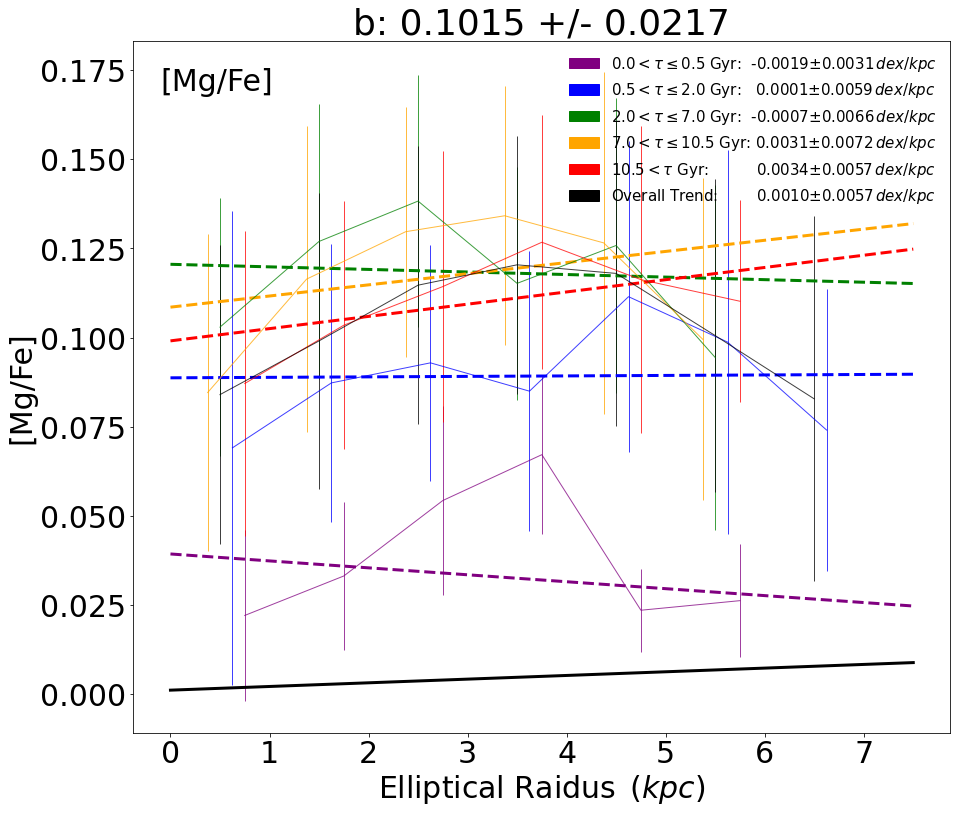

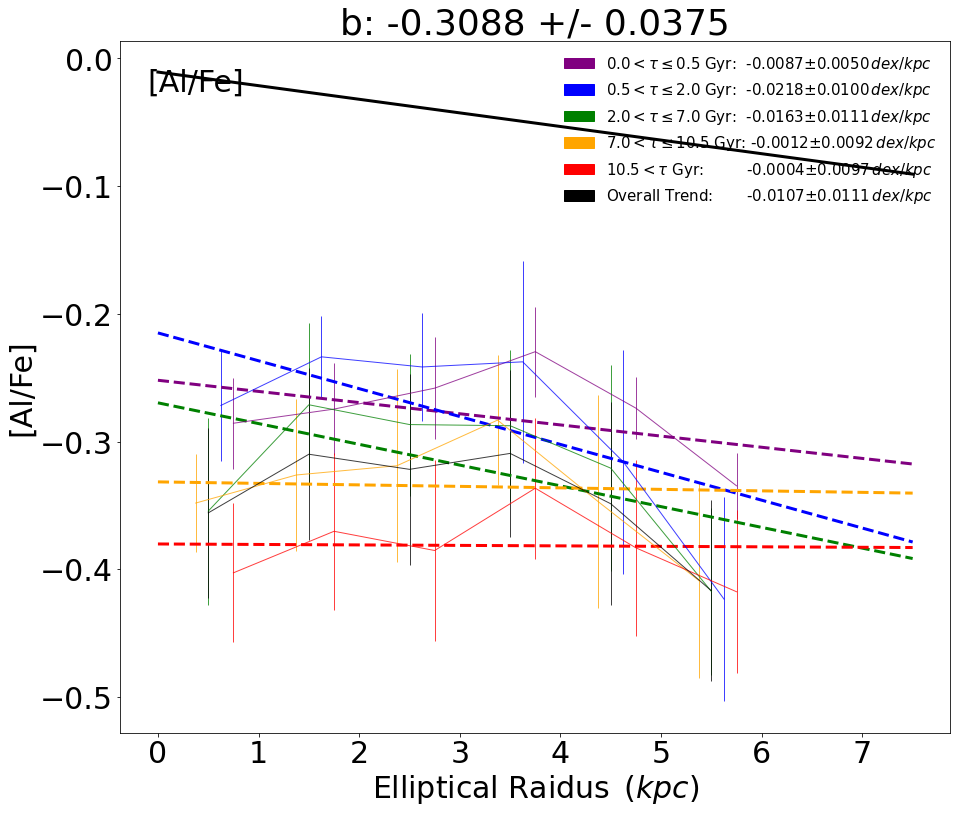

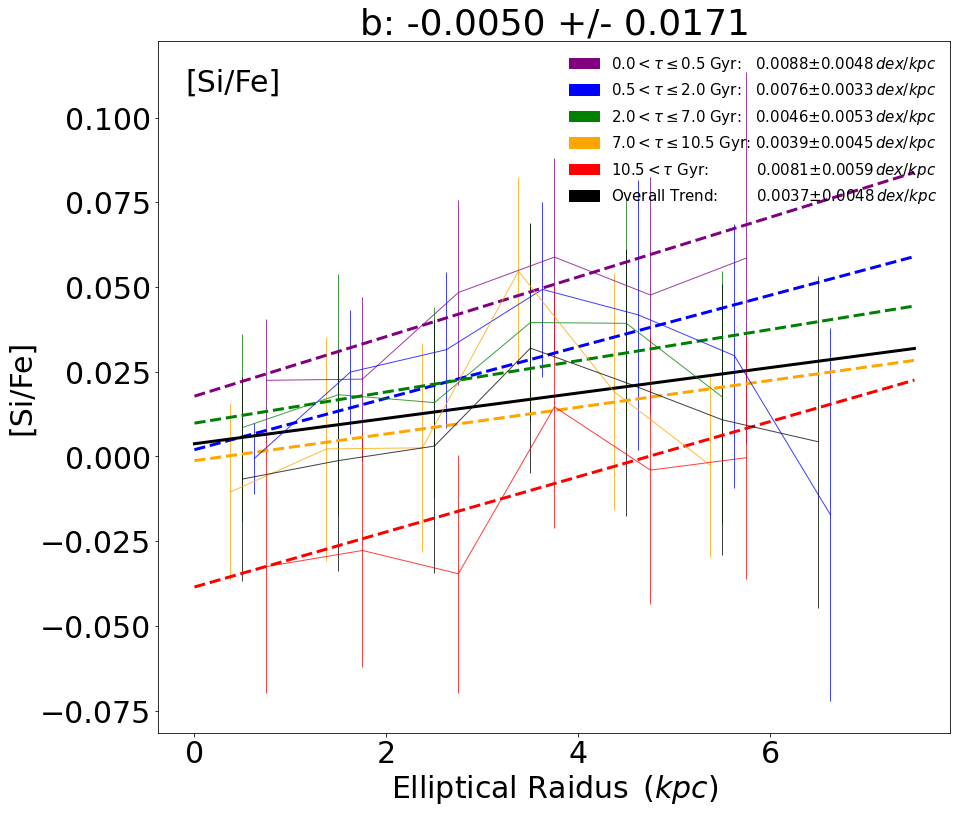

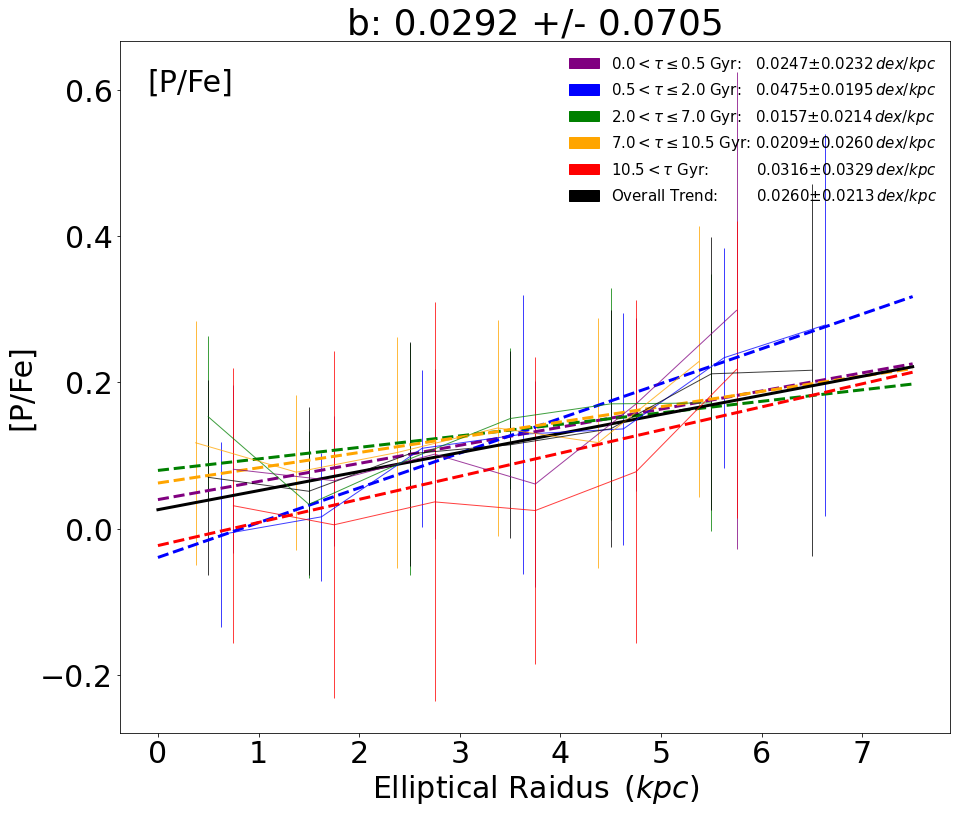

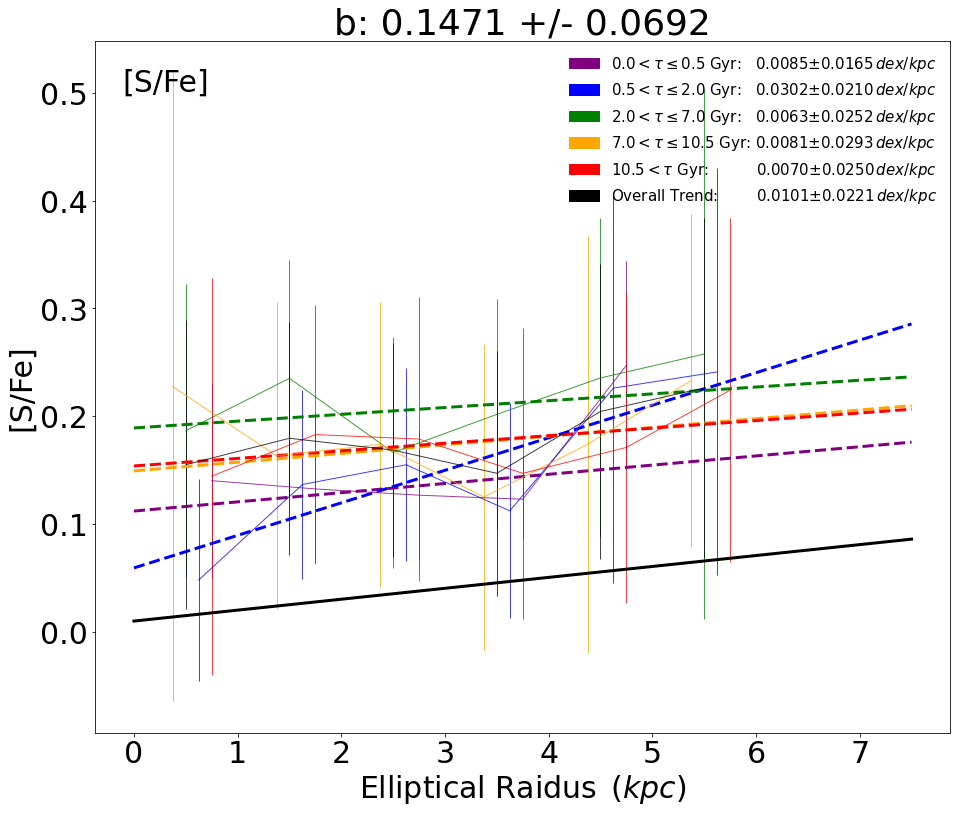

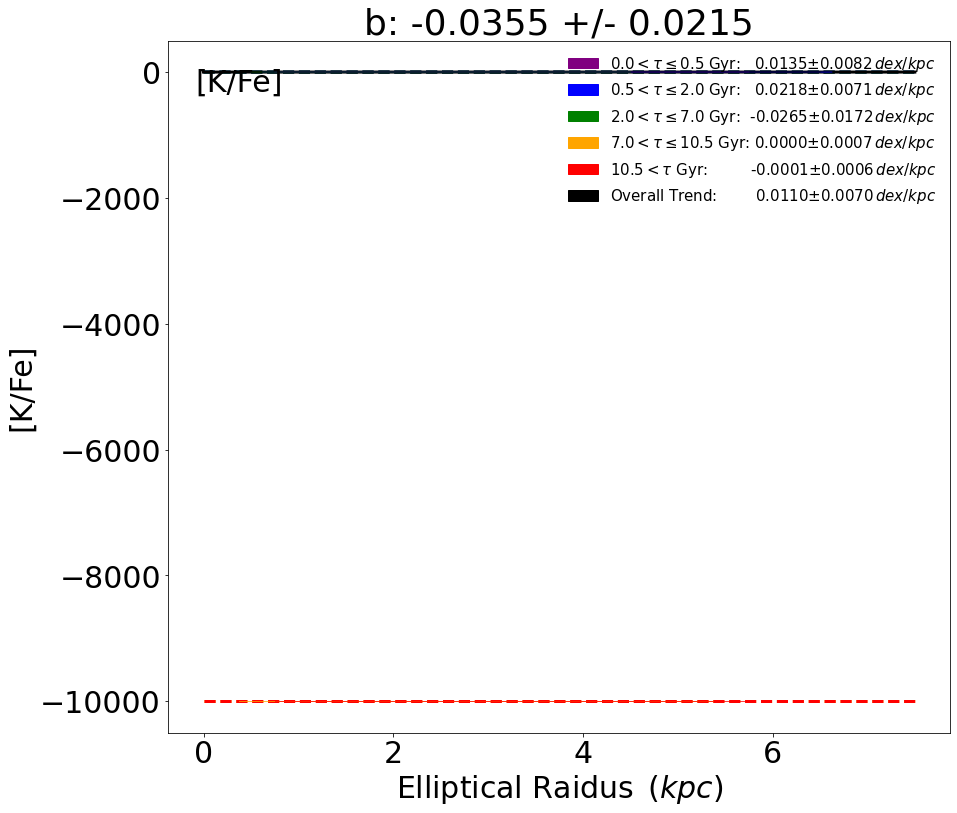

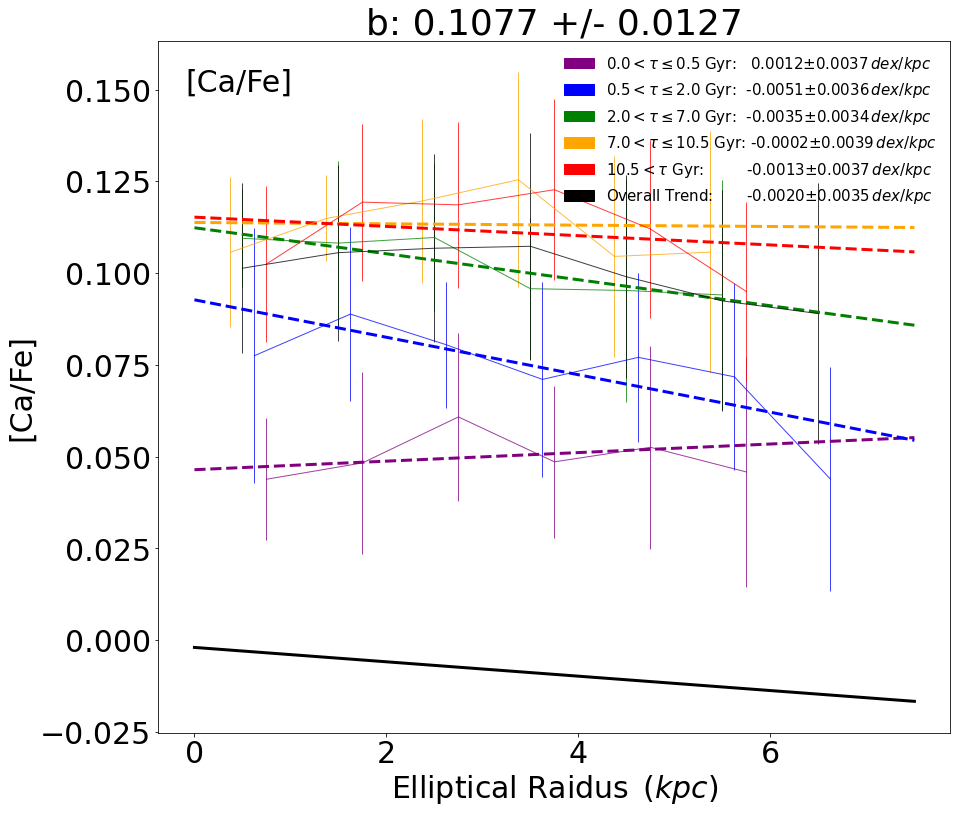

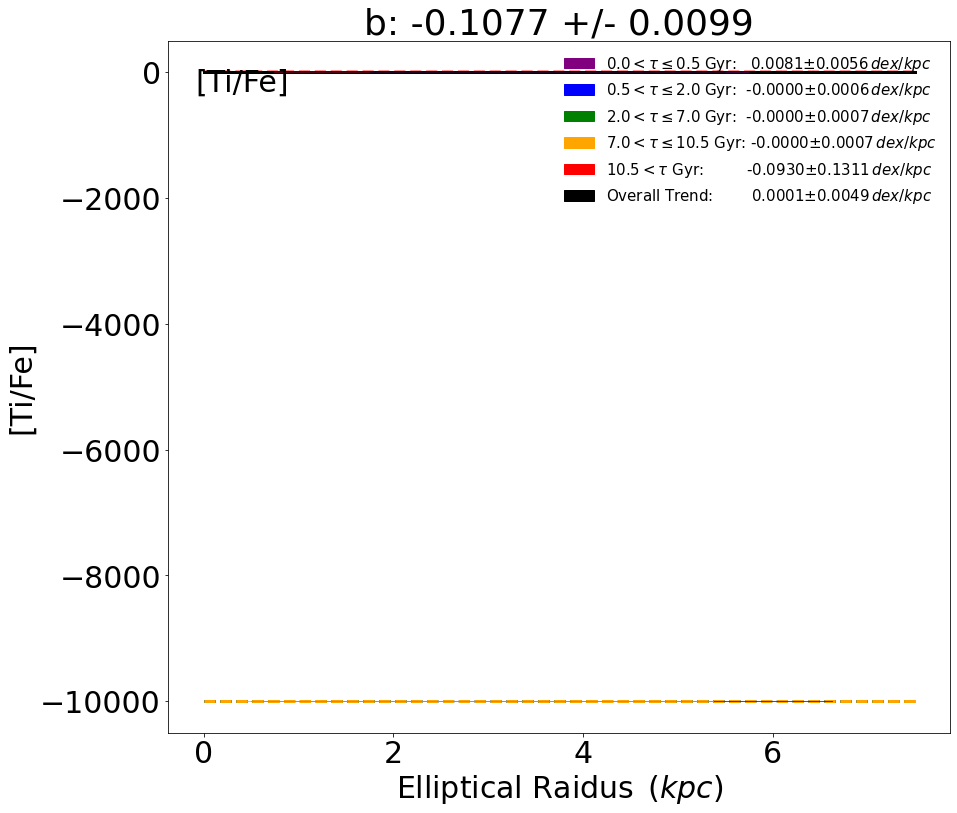

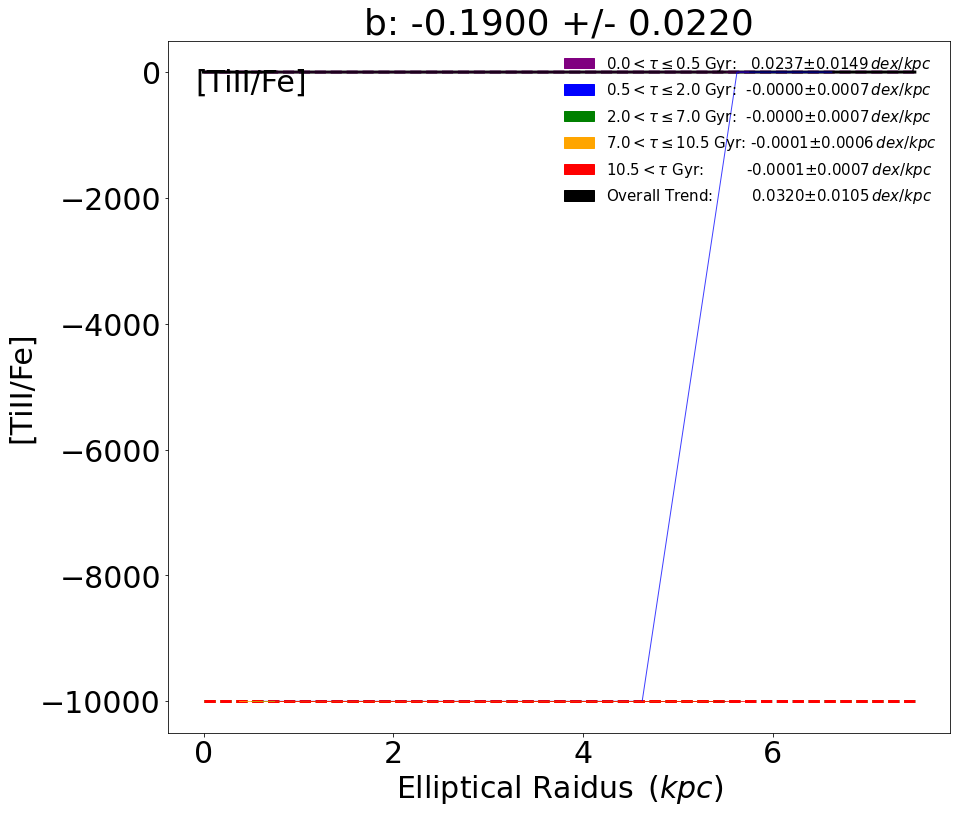

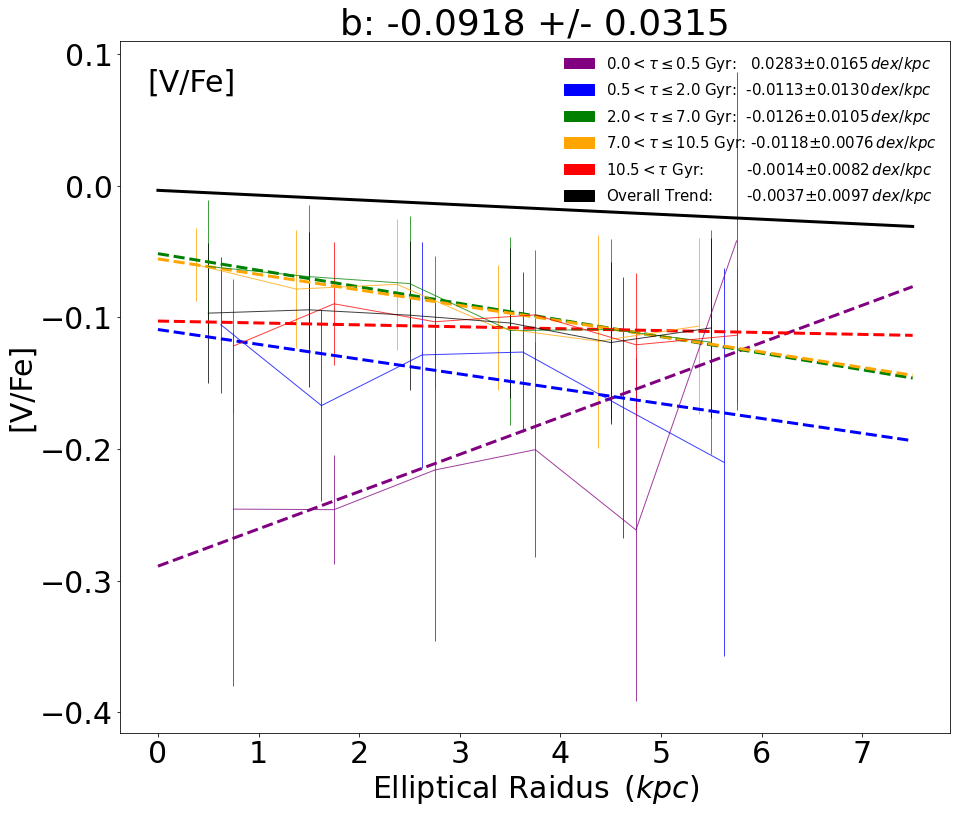

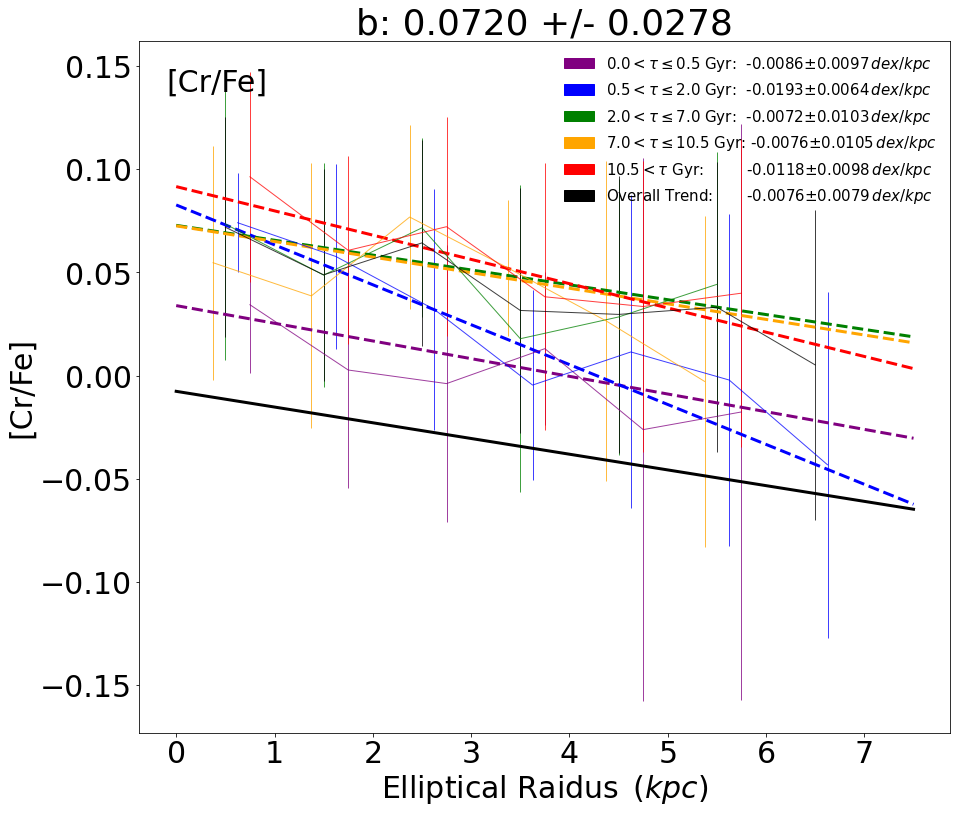

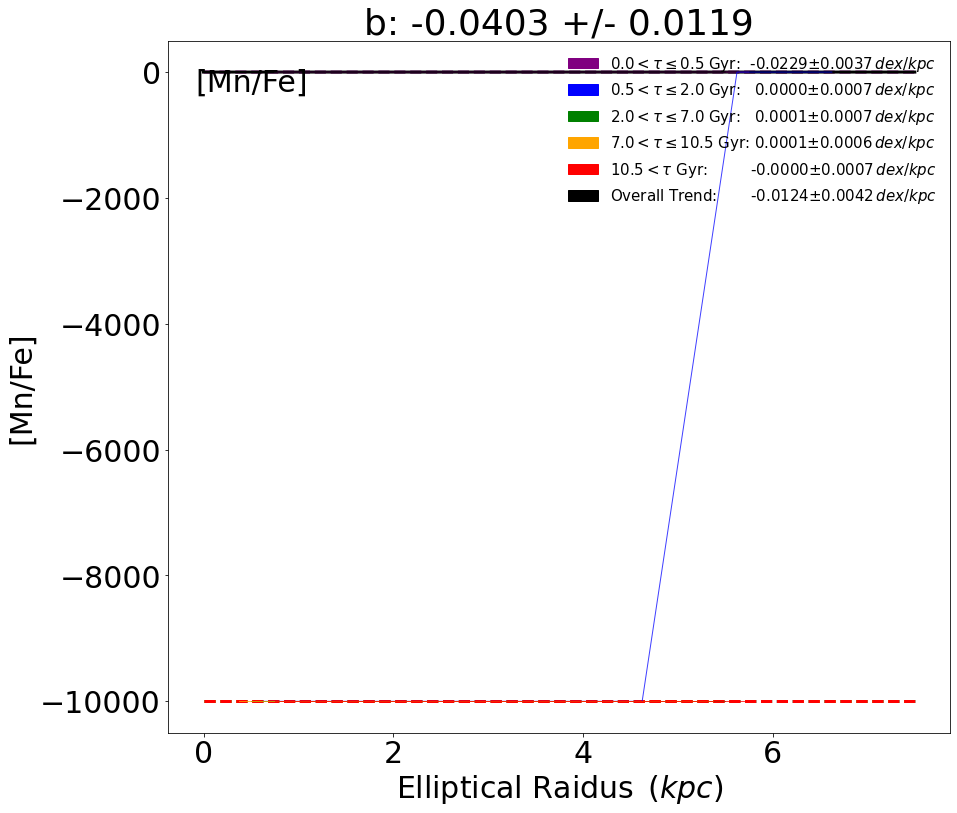

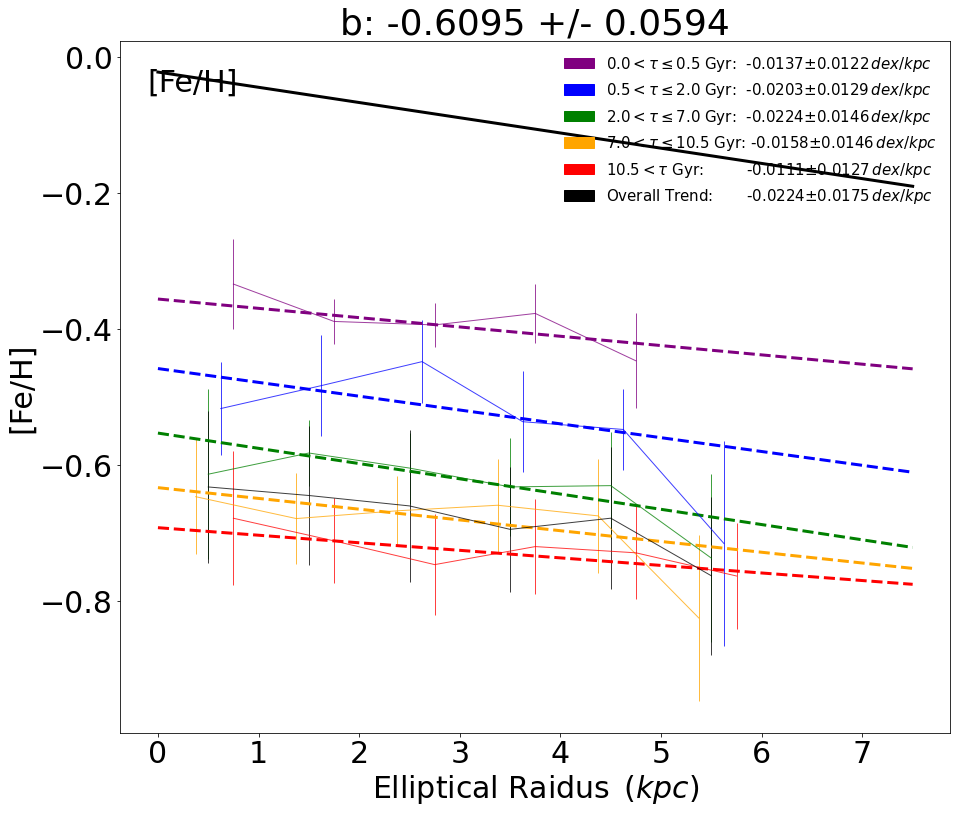

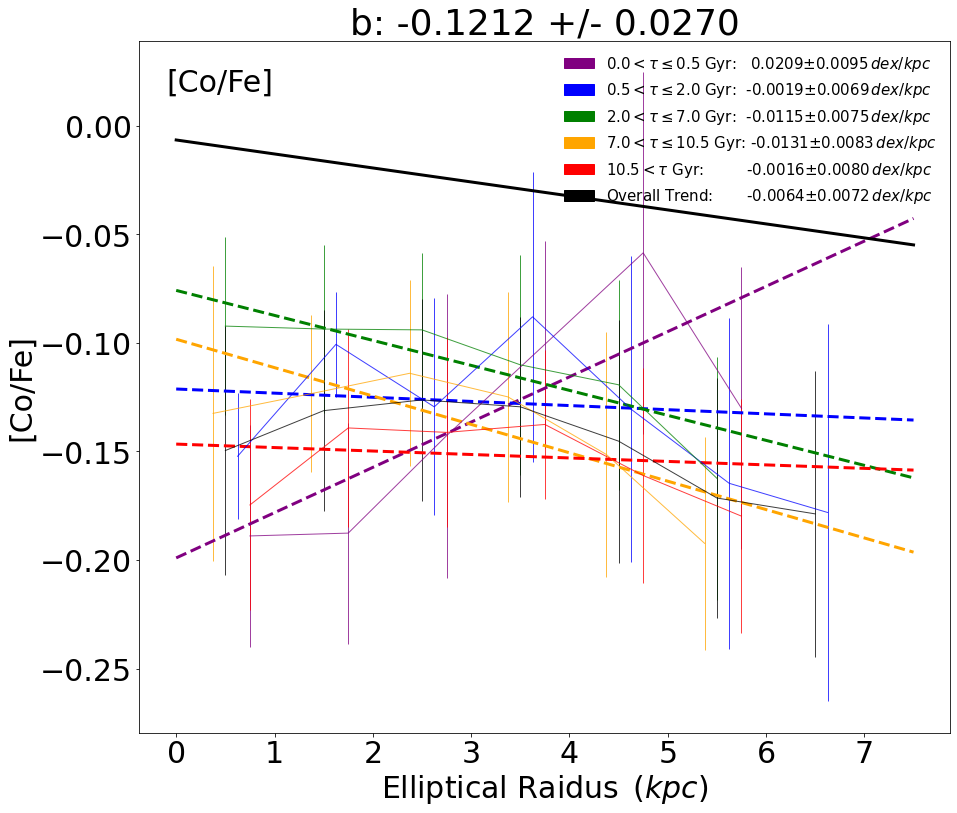

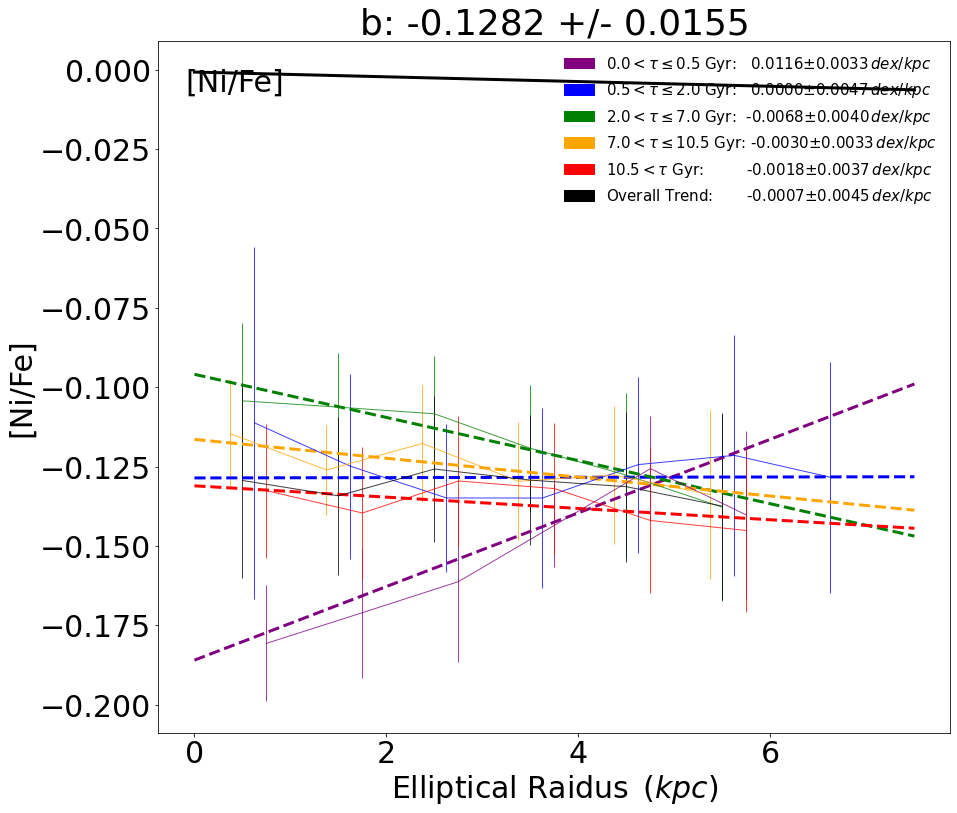

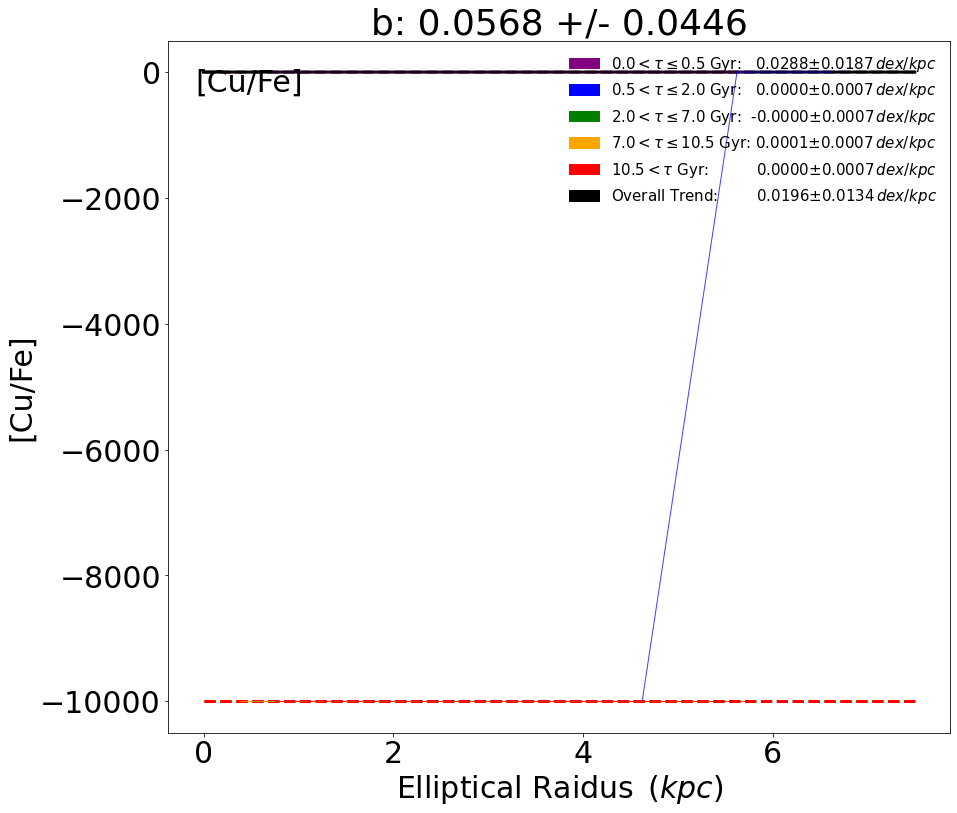

In [29]:
ytops = [0,0.1,0.7,0.2,1.0,0.4,0,0.325,2.0,0.8,0.8,0.3,0,0,0.75,0.4,0,0.0,0.5,0.0,0,0,0,0,0,0]

matplotlib.rcParams.update({'font.size': 30})
import matplotlib.patches as mpatches

young_parage = np.asarray(ages)[young]
yless_parage = np.asarray(ages)[yless]
ymed_parage = np.asarray(ages)[ymed]
omed_parage = np.asarray(ages)[omed]
old_parage = np.asarray(ages)[old]

for i in tqdm_notebook(range(len(elems)-5),desc='plots',leave=False):
    xval = np.linspace(0.0,7.5)
    
    def youngtrendline(x):
        return re_young_ms[i]*x+re_young_bs[i]
    def ylesstrendline(x):
        return re_yless_ms[i]*x+re_yless_bs[i]
    def ymedtrendline(x):
        return re_ymed_ms[i]*x+re_ymed_bs[i]
    def omedtrendline(x):
        return re_omed_ms[i]*x+re_omed_bs[i]
    def oldtrendline(x):
        return re_old_ms[i]*x+re_old_bs[i]
    def trendline(x):
        return re_ms[i]*x+re_ms[i]
        
    fig = plt.figure(figsize=[14,12])
    
    ### young
    plt.errorbar(np.arange(len(young_stats[i]))+0.5+0.25,young_stats[i],yerr=young_spread[i],color='purple',
                 ls='-',alpha=0.75,lw=1)
#     plt.plot(np.arange(len(young_stats[i]))+0.5+0.125,young_stats[i],color='purple')
    plt.plot(xval,youngtrendline(xval),c='purple',lw=3.0,ls='--') #young
    
    ### yless
    plt.errorbar(np.arange(len(yless_stats[i]))+0.5+0.125,yless_stats[i],yerr=yless_spread[i],color='blue',
                 ls='-',alpha=0.75,lw=1)
#     plt.plot(np.arange(len(yless_stats[i]))+0.5+0.25,yless_stats[i],color='blue')
    plt.plot(xval,ylesstrendline(xval),c='blue',lw=3.0,ls='--') #yless
    
    ### ymed
    plt.errorbar(np.arange(len(ymed_stats[i]))+0.5-0.,ymed_stats[i],yerr=ymed_spread[i],color='green',
                 ls='-',alpha=0.75,lw=1)
#     plt.plot(np.arange(len(ymed_stats[i]))+0.5+0.25,ymed_stats[i],color='green')
    plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0,ls='--') #ymed

    ### omed
    plt.errorbar(np.arange(len(omed_stats[i]))+0.5-0.125,omed_stats[i],yerr=omed_spread[i],color='orange',
                 ls='-',alpha=0.75,lw=1)
#     plt.plot(np.arange(len(omed_stats[i]))+0.5+0.25,omed_stats[i],color='orange')
    plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0,ls='--') #omed
    

    ### old
    plt.errorbar(np.arange(len(old_stats[i]))+0.5+0.25,old_stats[i],yerr=old_spread[i],color='red',
                 ls='-',alpha=0.75,lw=1)
#     plt.plot(np.arange(len(old_stats[i]))+0.5+0.25,old_stats[i],color='red')
    plt.plot(xval,oldtrendline(xval),c='red',lw=3.0,ls='--') #old
    
    ### overall
    plt.errorbar(np.arange(len(over_stats[i]))+0.5+0.,over_stats[i],yerr=over_spread[i],color='k',
                 ls='-',alpha=0.75,lw=1)
#     plt.plot(np.arange(len(over_stats[i]))+0.5+0.25,over_stats[i],color='k')
    plt.plot(xval,trendline(xval),c='k',lw=3.0)
    
    handles,labels = plt.gca().get_legend_handles_labels()
    empty_young = mpatches.Patch(color='purple',label='$0.0 < \\tau \leq 0.5$ Gyr')
    empty_yless = mpatches.Patch(color='blue',label='$0.5 < \\tau \leq 2.0$ Gyr')
    empty_ymed = mpatches.Patch(color='green',label='$2.0 < \\tau \leq 7.0$ Gyr')
    empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
    empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
    empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
    handles.append(empty_young)
    handles.append(empty_yless)
    handles.append(empty_ymed)
    handles.append(empty_omed)
    handles.append(empty_old)
    handles.append(empty_over)
    
    labels.append('$0.0 < \\tau \leq 0.5$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[i],
                                                                                      re_young_ms_err[i]))
    labels.append('$0.5 < \\tau \leq 2.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_yless_ms[i],
                                                                                      re_yless_ms_err[i]))
    labels.append('$2.0 < \\tau \leq 7.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_ymed_ms[i],
                                                                                      re_ymed_ms_err[i]))
    labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.4f}$\pm {:.4f} \,dex/kpc$'.format(re_omed_ms[i],
                                                                                       re_omed_ms_err[i]))
    labels.append('$10.5 < \\tau$ Gyr: {:>15.4f}$\pm {:.4f} \,dex/kpc$'.format(re_old_ms[i],
                                                                               re_old_ms_err[i]))
    labels.append('Overall Trend: {:>13.4f}$\pm {:.4f} \,dex/kpc$'.format(re_ms[i],
                                                                          re_ms_err[i]))
    
    plt.legend(handles,labels,loc='upper right',fontsize=15,frameon=False)

    plt.ylabel(r'{}'.format(labs[i]),fontsize=30)
    plt.xlabel(r'Elliptical Raidus $\,(kpc$)')
    
    plt.title(r'b: {:.4f} +/- {:.4f}'.format(re_bs[i],re_bs_err[i]))
#     plt.ylim(top = ytops[i])
        
#     if elems[i] == 'NA_FE':
#         plt.ylim(-0.35,0.)
    
    ax0 = fig.add_subplot(111)
    at0 = AnchoredText('{}'.format(labs[i]),prop=dict(size=30),frameon=False,loc='upper left')
    at0.patch.set_boxstyle("square")
    ax0.add_artist(at0)
    
#     plt.savefig('medians_age_bins_{}2.png'.format(els[i]),bbox_inches='tight')
    plt.tight_layout()
#     plt.savefig('../figures/medians_age_trends_{}.pdf'.format(elems[i]),bbox_inches='tight')
    plt.show()

In [16]:
###############################################
### Create Fits File with All the Gradients ###
###############################################

### OVERALL
over_elems = fits.Column(name='X_FE',array=np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe',
                                                     'P_Fe','S_Fe','K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe',
                                                     'Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe']),format='5A')
over_grad = fits.Column(name='GRAD',array=np.asarray(re_ms),format='D')
over_grad_err = fits.Column(name='GRAD_ERR',array=np.asarray(re_ms_err),format='D')
over_inter = fits.Column(name='INTER',array=np.asarray(re_bs),format='D')
over_inter_err = fits.Column(name='INTER_ERR',array=np.asarray(re_bs_err),format='D')

over_hdu = fits.BinTableHDU.from_columns([over_elems, over_grad, over_grad_err, over_inter, over_inter_err])

### YOUNG
young_elems = fits.Column(name='X_FE',array=np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe',
                                                     'P_Fe','S_Fe','K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe',
                                                     'Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe']),format='5A')
young_grad = fits.Column(name='GRAD',array=np.asarray(re_young_ms),format='D')
young_grad_err = fits.Column(name='GRAD_ERR',array=np.asarray(re_young_ms_err),format='D')
young_inter = fits.Column(name='INTER',array=np.asarray(re_bs),format='D')
young_inter_err = fits.Column(name='INTER_ERR',array=np.asarray(re_young_bs_err),format='D')

young_hdu = fits.BinTableHDU.from_columns([young_elems, young_grad, young_grad_err, young_inter, young_inter_err])

### YLESS
yless_elems = fits.Column(name='X_FE',array=np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe',
                                                     'P_Fe','S_Fe','K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe',
                                                     'Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe']),format='5A')
yless_grad = fits.Column(name='GRAD',array=np.asarray(re_yless_ms),format='D')
yless_grad_err = fits.Column(name='GRAD_ERR',array=np.asarray(re_yless_ms_err),format='D')
yless_inter = fits.Column(name='INTER',array=np.asarray(re_bs),format='D')
yless_inter_err = fits.Column(name='INTER_ERR',array=np.asarray(re_yless_bs_err),format='D')

yless_hdu = fits.BinTableHDU.from_columns([yless_elems, yless_grad, yless_grad_err, yless_inter, yless_inter_err])

### YMED
ymed_elems = fits.Column(name='X_FE',array=np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe',
                                                     'P_Fe','S_Fe','K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe',
                                                     'Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe']),format='5A')
ymed_grad = fits.Column(name='GRAD',array=np.asarray(re_ymed_ms),format='D')
ymed_grad_err = fits.Column(name='GRAD_ERR',array=np.asarray(re_ymed_ms_err),format='D')
ymed_inter = fits.Column(name='INTER',array=np.asarray(re_bs),format='D')
ymed_inter_err = fits.Column(name='INTER_ERR',array=np.asarray(re_ymed_bs_err),format='D')

ymed_hdu = fits.BinTableHDU.from_columns([ymed_elems, ymed_grad, ymed_grad_err, ymed_inter, ymed_inter_err])

### OMED
omed_elems = fits.Column(name='X_FE',array=np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe',
                                                     'P_Fe','S_Fe','K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe',
                                                     'Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe']),format='5A')
omed_grad = fits.Column(name='GRAD',array=np.asarray(re_omed_ms),format='D')
omed_grad_err = fits.Column(name='GRAD_ERR',array=np.asarray(re_omed_ms_err),format='D')
omed_inter = fits.Column(name='INTER',array=np.asarray(re_omed_bs),format='D')
omed_inter_err = fits.Column(name='INTER_ERR',array=np.asarray(re_omed_bs_err),format='D')

omed_hdu = fits.BinTableHDU.from_columns([omed_elems, omed_grad, omed_grad_err, omed_inter, omed_inter_err])

### OLD
old_elems = fits.Column(name='X_FE',array=np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe',
                                                     'P_Fe','S_Fe','K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe',
                                                     'Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe']),format='5A')
old_grad = fits.Column(name='GRAD',array=np.asarray(re_old_ms),format='D')
old_grad_err = fits.Column(name='GRAD_ERR',array=np.asarray(re_old_ms_err),format='D')
old_inter = fits.Column(name='INTER',array=np.asarray(re_old_bs),format='D')
old_inter_err = fits.Column(name='INTER_ERR',array=np.asarray(re_old_bs_err),format='D')

old_hdu = fits.BinTableHDU.from_columns([old_elems, old_grad, old_grad_err, old_inter, old_inter_err])

hdu1 = fits.HDUList([over_hdu, young_hdu, yless_hdu, ymed_hdu, omed_hdu, old_hdu])
# hdu1.writeto('mcmc_lmc_grads.fits',output_verify='ignore',overwrite=True)

In [63]:
prune_fact = 3.0

radiusyoung = radius[young]
radiusyless = radius[yless]
radiusymed = radius[ymed]
radiusomed = radius[omed]
radiusold = radius[old]

### young
young_stats = [] 
young_spread = []

for i in range(len(elems)-5):
    cln = np.where(lmcyoung[elems[i]]>-100.)
    young_cln = np.where((lmcyoung[elems[i]]>-prune_fact*mc.mad(young_dist[i])+
                          np.median(lmcyoung[cln][elems[i]]))&
                         (lmcyoung[elems[i]]<prune_fact*mc.mad(young_dist[i])+
                          np.median(lmcyoung[cln][elems[i]])))
    try:
        bins = np.arange(np.floor(np.min(radiusyoung[young_cln])),np.ceil(np.max(radiusyoung[young_cln])),1)
        young_bin_stats, _, young_binnumber = binned_statistic(radiusyoung[young_cln],
                                                                         lmcyoung[elems[i]][young_cln],
                                                                         statistic='median',bins=bins)


#         young_mad = []
#         for i in np.unique(young_binnumber)[:-1]:
#             young_mad.append(mc.mad(lmcyoung[elems[i]][young_cln][np.where(young_binnumber==i)]))
#         young_mad = np.asarray(young_mad)

        young_mad, _, _ = binned_statistic(radiusyoung[young_cln],lmcyoung[elems[i]][young_cln],
                                           statistic=lambda y: util.mad(y),bins=bins)
                                                                        
        young_stats.append(young_bin_stats)
        young_spread.append(young_mad)
    
    except:
        young_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        young_spread.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        
young_stats = np.asarray(young_stats)
young_spread = np.asarray(young_spread)
        
### yless
yless_stats = [] 
yless_spread = []

for i in range(len(elems)-5):
    cln = np.where(lmcyless[elems[i]]>-100.)
    yless_cln = np.where((lmcyless[elems[i]]>-prune_fact*mc.mad(yless_dist[i])+
                          np.median(lmcyless[cln][elems[i]]))&
                         (lmcyless[elems[i]]<prune_fact*mc.mad(yless_dist[i])+
                          np.median(lmcyless[cln][elems[i]])))
    try:
        bins = np.arange(np.floor(np.min(radiusyless[yless_cln])),np.ceil(np.max(radiusyless[yless_cln])),1)
        yless_bin_stats, _, yless_binnumber = binned_statistic(radiusyless[yless_cln],
                                                                         lmcyless[elems[i]][yless_cln],
                                                                         statistic='median',bins=bins)


#         yless_mad = []
#         for i in np.unique(yless_binnumber)[:-1]:
#             yless_mad.append(mc.mad(lmcyless[elems[i]][yless_cln][np.where(yless_binnumber==i)]))
#         yless_mad = np.asarray(yless_mad)

        yless_mad, _, _ = binned_statistic(radiusyless[yless_cln],lmcyless[elems[i]][yless_cln],
                                           statistic=lambda y: util.mad(y),bins=bins)
                                                                        
        yless_stats.append(yless_bin_stats)
        yless_spread.append(yless_mad)
    
    except:
        yless_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        yless_spread.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        
yless_stats = np.asarray(yless_stats)
yless_spread = np.asarray(yless_spread)
        
### ymed
ymed_stats = [] 
ymed_spread = []

for i in range(len(elems)-5):
    cln = np.where(lmcymed[elems[i]]>-100.)
    ymed_cln = np.where((lmcymed[elems[i]]>-prune_fact*mc.mad(ymed_dist[i])+
                          np.median(lmcymed[cln][elems[i]]))&
                         (lmcymed[elems[i]]<prune_fact*mc.mad(ymed_dist[i])+
                          np.median(lmcymed[cln][elems[i]])))
    try:
        bins = np.arange(np.floor(np.min(radiusymed[ymed_cln])),np.ceil(np.max(radiusymed[ymed_cln])),1)
        ymed_bin_stats, _, ymed_binnumber = binned_statistic(radiusymed[ymed_cln],
                                                                         lmcymed[elems[i]][ymed_cln],
                                                                         statistic='median',bins=bins)


#         ymed_mad = []
#         for i in np.unique(ymed_binnumber)[:-1]:
#             ymed_mad.append(mc.mad(lmcymed[elems[i]][ymed_cln][np.where(ymed_binnumber==i)]))
#         ymed_mad = np.asarray(ymed_mad)

        ymed_mad, _, _ = binned_statistic(radiusymed[ymed_cln],lmcymed[elems[i]][ymed_cln],
                                           statistic=lambda y: util.mad(y),bins=bins)
                                                                        
        ymed_stats.append(ymed_bin_stats)
        ymed_spread.append(ymed_mad)
    
    except:
        ymed_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        ymed_spread.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        
ymed_stats = np.asarray(ymed_stats)
ymed_spread = np.asarray(ymed_spread)
        
### omed
omed_stats = [] 
omed_spread = []

for i in range(len(elems)-5):
    cln = np.where(lmcomed[elems[i]]>-100.)
    omed_cln = np.where((lmcomed[elems[i]]>-prune_fact*mc.mad(omed_dist[i])+
                          np.median(lmcomed[cln][elems[i]]))&
                         (lmcomed[elems[i]]<prune_fact*mc.mad(omed_dist[i])+
                          np.median(lmcomed[cln][elems[i]])))
    try:
        bins = np.arange(np.floor(np.min(radiusomed[omed_cln])),np.ceil(np.max(radiusomed[omed_cln])),1)
        omed_bin_stats, _, omed_binnumber = binned_statistic(radiusomed[omed_cln],
                                                                         lmcomed[elems[i]][omed_cln],
                                                                         statistic='median',bins=bins)


#         omed_mad = []
#         for i in np.unique(omed_binnumber)[:-1]:
#             omed_mad.append(mc.mad(lmcomed[elems[i]][omed_cln][np.where(omed_binnumber==i)]))
#         omed_mad = np.asarray(omed_mad)

        omed_mad, _, _ = binned_statistic(radiusomed[omed_cln],lmcomed[elems[i]][omed_cln],
                                           statistic=lambda y: util.mad(y),bins=bins)
                                                                        
        omed_stats.append(omed_bin_stats)
        omed_spread.append(omed_mad)
    
    except:
        omed_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        omed_spread.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        
omed_stats = np.asarray(omed_stats)
omed_spread = np.asarray(omed_spread)
        
### old
old_stats = [] 
old_spread = []

for i in range(len(elems)-5):
    cln = np.where(lmcold[elems[i]]>-100.)
    old_cln = np.where((lmcold[elems[i]]>-prune_fact*mc.mad(old_dist[i])+
                          np.median(lmcold[cln][elems[i]]))&
                         (lmcold[elems[i]]<prune_fact*mc.mad(old_dist[i])+
                          np.median(lmcold[cln][elems[i]])))
    try:
        bins = np.arange(np.floor(np.min(radiusold[old_cln])),np.ceil(np.max(radiusold[old_cln])),1)
        old_bin_stats, _, old_binnumber = binned_statistic(radiusold[old_cln],
                                                                         lmcold[elems[i]][old_cln],
                                                                         statistic='median',bins=bins)


#         old_mad = []
#         for i in np.unique(old_binnumber)[:-1]:
#             old_mad.append(mc.mad(lmcold[elems[i]][old_cln][np.where(old_binnumber==i)]))
#         old_mad = np.asarray(old_mad)

        old_mad, _, _ = binned_statistic(radiusold[old_cln],lmcold[elems[i]][old_cln],
                                           statistic=lambda y: util.mad(y),bins=bins)
                                                                        
        old_stats.append(old_bin_stats)
        old_spread.append(old_mad)
    
    except:
        old_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        old_spread.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        
old_stats = np.asarray(old_stats)
old_spread = np.asarray(old_spread)

In [64]:
### YOUNG
cp_young_stats = np.copy(young_stats).tolist()
cp_young_spread = np.copy(young_spread).tolist()

for i in range(len(cp_young_stats)):
    if len(cp_young_stats[i])<6:
        cp_young_stats[i] = np.append(cp_young_stats[i],-9999.0*np.ones(6-len(cp_young_stats[i])))
        cp_young_spread[i] = np.append(cp_young_spread[i],-9999.0*np.ones(6-len(cp_young_spread[i])))
        
youngtrendcat = Table()
youngtrendcol_elems = Column(np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe',
                                  'K_Fe','Ca_Fe_','Ti_Fe','TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe',
                                  'Ni_Fe','Cu_Fe']),name='X_FE')
youngtrendcol_stats = Column(np.squeeze(np.asarray(cp_young_stats)),name='STATS')
youngtrendcol_spread = Column(np.asarray(cp_young_spread),name='SPREAD')

youngtrendcat.add_column(youngtrendcol_elems)
youngtrendcat.add_column(youngtrendcol_stats)
youngtrendcat.add_column(youngtrendcol_spread)

# youngtrendcat.write('youngtrends.fits',overwrite=True)

### yless
cp_yless_stats = np.copy(yless_stats).tolist()
cp_yless_spread = np.copy(yless_spread).tolist()

for i in range(len(cp_yless_stats)):
    if len(cp_yless_stats[i])<7:
        cp_yless_stats[i] = np.append(cp_yless_stats[i],-9999.0*np.ones(7-len(cp_yless_stats[i])))
        cp_yless_spread[i] = np.append(cp_yless_spread[i],-9999.0*np.ones(7-len(cp_yless_spread[i])))
        
ylesstrendcat = Table()
ylesstrendcol_elems = Column(np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe',
                                  'K_Fe','Ca_Fe_','Ti_Fe','TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe',
                                  'Ni_Fe','Cu_Fe']),name='X_FE')
ylesstrendcol_stats = Column(np.squeeze(np.asarray(cp_yless_stats)),name='STATS')
ylesstrendcol_spread = Column(np.asarray(cp_yless_spread),name='SPREAD')

ylesstrendcat.add_column(ylesstrendcol_elems)
ylesstrendcat.add_column(ylesstrendcol_stats)
ylesstrendcat.add_column(ylesstrendcol_spread)

# ylesstrendcat.write('ylesstrends.fits',overwrite=True)

### YMED
cp_ymed_stats = np.copy(ymed_stats).tolist()
cp_ymed_spread  = np.copy(ymed_spread).tolist()

for i in range(len(cp_ymed_stats)):
    if len(cp_ymed_stats[i])<6:
        cp_ymed_stats[i] = np.append(cp_ymed_stats[i],-9999.0*np.ones(6-len(cp_ymed_stats[i])))
        cp_ymed_spread[i] = np.append(cp_ymed_spread[i],-9999.0*np.ones(6-len(cp_ymed_spread[i])))
        
ymedtrendcat = Table()
ymedtrendcol_elems = Column(np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe',
                                  'K_Fe','Ca_Fe_','Ti_Fe','TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe',
                                  'Ni_Fe','Cu_Fe']),name='X_FE')
ymedtrendcol_stats = Column(np.squeeze(np.asarray(cp_ymed_stats)),name='STATS')
ymedtrendcol_spread = Column(np.asarray(cp_ymed_spread),name='SPREAD')

ymedtrendcat.add_column(ymedtrendcol_elems)
ymedtrendcat.add_column(ymedtrendcol_stats)
ymedtrendcat.add_column(ymedtrendcol_spread)

# ymedtrendcat.write('ymedtrends.fits',overwrite=True)

### OMED
cp_omed_stats = np.copy(omed_stats).tolist()
cp_omed_spread  = np.copy(omed_spread).tolist()

for i in range(len(cp_omed_stats)):
    if len(cp_omed_stats[i])<6:
        cp_omed_stats[i] = np.append(cp_omed_stats[i],-9999.0*np.ones(6-len(cp_omed_stats[i])))
        cp_omed_spread[i] = np.append(cp_omed_spread[i],-9999.0*np.ones(6-len(cp_omed_spread[i])))
        
omedtrendcat = Table()
omedtrendcol_elems = Column(np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe',
                                  'K_Fe','Ca_Fe_','Ti_Fe','TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe',
                                  'Ni_Fe','Cu_Fe']),name='X_FE')
omedtrendcol_stats = Column(np.squeeze(np.asarray(cp_omed_stats)),name='STATS')
omedtrendcol_spread = Column(np.asarray(cp_omed_spread),name='SPREAD')

omedtrendcat.add_column(omedtrendcol_elems)
omedtrendcat.add_column(omedtrendcol_stats)
omedtrendcat.add_column(omedtrendcol_spread)

# omedtrendcat.write('omedtrends.fits',overwrite=True)

### OLD
cp_old_stats = np.copy(old_stats).tolist()
cp_old_spread  = np.copy(old_spread).tolist()

for i in range(len(cp_old_stats)):
    if len(cp_old_stats[i])<6:
        cp_old_stats[i] = np.append(cp_old_stats[i],-9999.0*np.ones(6-len(cp_old_stats[i])))
        cp_old_spread[i] = np.append(cp_old_spread[i],-9999.0*np.ones(6-len(cp_old_spread[i])))
        
oldtrendcat = Table()
oldtrendcol_elems = Column(np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe',
                                  'K_Fe','Ca_Fe_','Ti_Fe','TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe',
                                  'Ni_Fe','Cu_Fe']),name='X_FE')
oldtrendcol_stats = Column(np.squeeze(np.asarray(cp_old_stats)),name='STATS')
oldtrendcol_spread = Column(np.asarray(cp_old_spread),name='SPREAD')

oldtrendcat.add_column(oldtrendcol_elems)
oldtrendcat.add_column(oldtrendcol_stats)
oldtrendcat.add_column(oldtrendcol_spread)

# oldtrendcat.write('oldtrends.fits',overwrite=True)

In [57]:
###############################################
### Create Fits File with All the Gradients ###
###############################################

# ### YOUNG
# cp_young_stats = np.copy(young_stats).tolist()
# cp_young_spread = np.copy(young_spread).tolist()

# for i in range(len(cp_young_stats)):
#     if len(cp_young_stats[i])<6:
#         cp_young_stats[i] = np.append(cp_young_stats[i],-9999.0*np.ones(6-len(cp_young_stats[i])))
#         cp_young_spread[i] = np.append(cp_young_spread[i],-9999.0*np.ones(6-len(cp_young_spread[i])))

# young_elems = fits.Column(name='X_FE',array=np.asarray(elems[:-5]),format='5A')
# young_median = fits.Column(name='MED',array=np.squeeze(np.asarray(cp_young_stats)),format='D')
# young_mad = fits.Column(name='SPREAD',array=np.asarray(cp_young_spread),format='D')

# young_hdu = fits.BinTableHDU.from_columns([young_elems, young_median])

# ### YLESS
# yless_elems = fits.Column(name='X_FE',array=np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe',
#                                                      'P_Fe','S_Fe','K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe',
#                                                      'Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe']),format='5A')
# yless_median = fits.Column(name='MEDIAN',array=yless_stats,format='D')
# yless_mad = fits.Column(name='SPREAD',array=yless_spread,format='D')

# yless_hdu = fits.BinTableHDU.from_columns([yless_elems, yless_median, yless_mad])

# ### YMED
# ymed_elems = fits.Column(name='X_FE',array=np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe',
#                                                      'P_Fe','S_Fe','K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe',
#                                                      'Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe']),format='5A')
# ymed_median = fits.Column(name='MEDIAN',array=ymed_stats,format='D')
# ymed_mad = fits.Column(name='SPREAD',array=ymed_spread,format='D')

# ymed_hdu = fits.BinTableHDU.from_columns([ymed_elems, ymed_median, ymed_mad])

# ### OMED
# omed_elems = fits.Column(name='X_FE',array=np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe',
#                                                      'P_Fe','S_Fe','K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe',
#                                                      'Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe']),format='5A')
# omed_median = fits.Column(name='MEDIAN',array=omed_stats,format='D')
# omed_mad = fits.Column(name='SPREAD',array=omed_spread,format='D')

# omed_hdu = fits.BinTableHDU.from_columns([omed_elems, omed_median, omed_mad])

# ### OLD
# old_elems = fits.Column(name='X_FE',array=np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe',
#                                                      'P_Fe','S_Fe','K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe',
#                                                      'Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe']),format='5A')
# old_median = fits.Column(name='MEDIAN',array=old_stats,format='D')
# old_mad = fits.Column(name='SPREAD',array=old_spread,format='D')

# old_hdu = fits.BinTableHDU.from_columns([old_elems, old_median, old_mad])

# hdu2 = fits.HDUList([young_hdu, yless_hdu, ymed_hdu, omed_hdu, old_hdu])
# hdu2.writeto('mcmc_stats.fits',output_verify='ignore',overwrite=True)

ValueError: could not broadcast input array from shape (126) into shape (21)

In [55]:
len(np.squeeze(np.asarray(cp_young_stats)))==len(np.asarray(cp_young_spread))

True

In [ ]:
len()

In [45]:
elems[:-5]

['M_H',
 'C_FE',
 'N_FE',
 'O_FE',
 'NA_FE',
 'MG_FE',
 'AL_FE',
 'SI_FE',
 'P_FE',
 'S_FE',
 'K_FE',
 'CA_FE',
 'TI_FE',
 'TIII_FE',
 'V_FE',
 'CR_FE',
 'MN_FE',
 'FE_H',
 'CO_FE',
 'NI_FE',
 'CU_FE']

In [ ]:
old_elems = fits.Column(name='X_FE',array=np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe',
                                                     'P_Fe','S_Fe','K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe',
                                                     'Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe']),format='5A')
old_median = fits.Column(name='MEDIAN',array=np.asarray(old_stats),format='D')
old_mad = fits.Column(name='SPREAD',array=np.asarray(old_spread),format='D')

old_hdu = fits.BinTableHDU.from_columns([old_elems, old_median, old_mad])